In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import time
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scTools import input, preprocess, process, out
from scTools.process import draw
import gseapy

%load_ext autoreload
%autoreload 2

In [ ]:
h5ad=False

### Load adata objects
treatments = ['NonfatVehicle', 'FriedVehicle', 'FriedCRV431', 'FriedLANI', 'FriedCRVLAN']
if h5ad:
    path="/Volumes/Expansion/Hepion/ClusteringResults/"
    Data = input.loadAllFriedman(path)
else:
    mtxPath = "/Volumes/Expansion/Hepion/Data/"
    Data = {t:input.loadSTAR(f"{mtxPath}{t}/", labels=False, make_unique=False) for t in treatments}
    for t in treatments:
        preprocess.filter(Data[t], min_cells=5, min_genes=200)
        Data[t] = preprocess.mitoFilter(Data[t], plot=False)
        Data[t] = preprocess.riboFilter(Data[t], plot=False)
        Data[t] = Data[t][:,Data[t].X.sum(axis=0)>=10]
        Data[t].raw=Data[t]
        preprocess.logNorm(Data[t])
        #Data[t].raw = Data[t]
        #sc.pp.scale(Data[t], max_value=10)
        print(Data[t])
        
        print(Data[t].obs)

### To draw
doDraw=False
if doDraw:
    adata = process.catAdata(Data, Data.keys())
    preprocess.umapify(adata, color=['batch','fineClusters'], redoPCA=True)
    Data = { k:adata[adata.obs['batch']==k] for k in Data.keys() }
    preprocess.umapify(process.catAdata(Data, Data.keys(), obsKey='coarseClusters', obsVal='T Cells'), color=['batch','fineClusters'], redoPCA=False)
print(Data.keys())

In [47]:
count=0
for v in Data['FriedCRV431'].var_names.str.startswith('mt-'):
    if v==True:
        count+=1
print(count)
print(Data['FriedVehicle'].obs.sort_values('pct_counts_mt'))

2
                  coarseClusters    fineClusters  n_genes  n_genes_by_counts  \
AACACACTCGCCGAAC       Monocytes  CV & Cap. Macs      727                724   
GACCCAGGTCGACGCT     Neutrophils     Neutrophils     1082               1081   
GACTGATTCATCTACT     Neutrophils     Neutrophils      732                731   
GAGTGTTTCTTGGTGA     Neutrophils     Neutrophils      818                818   
GCAGCCAAGGTAGCCA     Neutrophils     Neutrophils     1238               1232   
GCCAGGTGTTCGGACC     Neutrophils     Neutrophils      893                889   
GGGAGATCAGATTTCG     Neutrophils     Neutrophils     1368               1366   
GGGATGATCATACAGC     Neutrophils     Neutrophils      862                860   
GGTGTCGCAGGTTCCG     Neutrophils     Neutrophils      599                596   
GTAGGTTAGCGATGAC     Neutrophils     Neutrophils      743                742   
GTGCACGGTAGGCAGT     Neutrophils     Neutrophils     1371               1366   
GTGTAACGTAAGCTCT     Neutrophils     N

None
AnnData object with n_obs × n_vars = 6194 × 15582
    obs: 'coarseClusters', 'fineClusters', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'


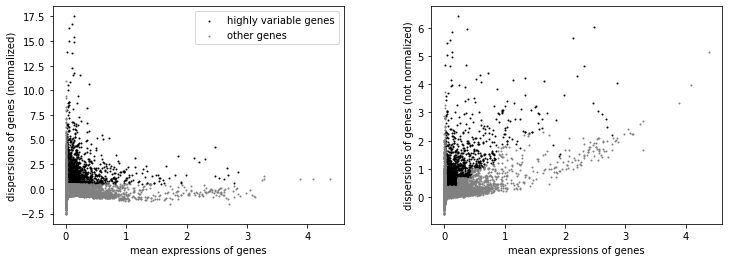

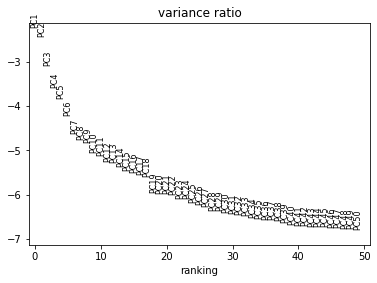

AnnData object with n_obs × n_vars = 6194 × 1605
    obs: 'coarseClusters', 'fineClusters', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


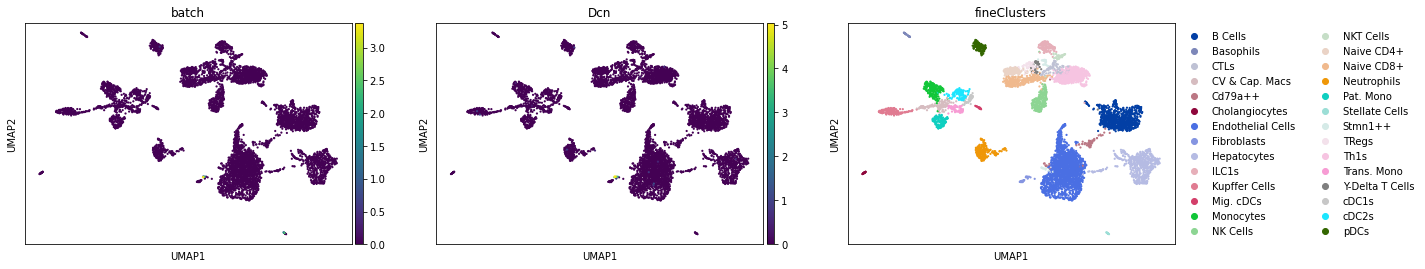

In [35]:
adata=None
print(adata)
'''
dataPath = "/Volumes/Expansion/Hepion/Data/"
for t in treatments:
    Data[t].obs['coarseClusters'].to_csv(f"{dataPath}{t}/coarseClusters.csv", index=True)
    Data[t].obs['fineClusters'].to_csv(f"{dataPath}{t}/fineClusters.csv", index=True)
'''
adata=Data['FriedCRVLAN'].copy()
print(adata)
adata=preprocess.hvg(adata, flavor='seurat')
adata.raw=adata
sc.pp.scale(adata, max_value=10)
preprocess.doPCA(adata, inplace=True)
print(adata)
#preprocess.fullEmbedShebang(adata)
preprocess.umapify(adata, color=['Col3a1','Dcn','fineClusters'], redoPCA=False)
adata=None

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/JackBrons/miniconda3/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


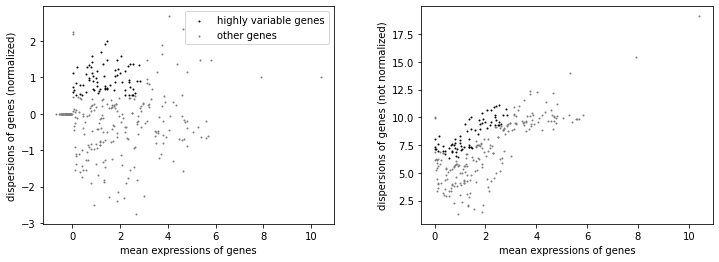

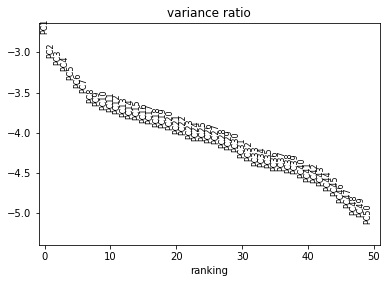

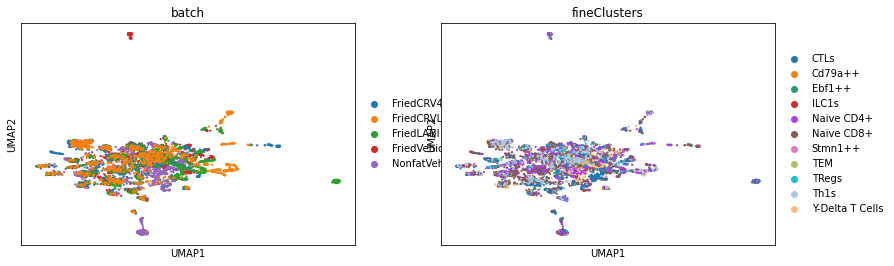

In [10]:
newData = process.batchIt(Data, inplace=False)
adata = process.catAdata(newData, newData.keys(), combat=True)

adata = adata[adata.obs['coarseClusters']=='T Cells']
adata=preprocess.hvg(adata)
preprocess.doPCA(adata)
preprocess.umapify(adata, color=['batch','fineClusters'])

['B Cells' 'Basophils' 'Cd79a++' 'Cholangiocytes' 'Endothelial Cells'
 'ILC1s' 'Mig. cDCs' 'Monocytes' 'NK Cells' 'Neutrophils' 'Stellate Cells'
 'Stmn1++' 'T Cells' 'cDC1s' 'cDC2s' 'pDCs']


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(2885, 13779)
PCA


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


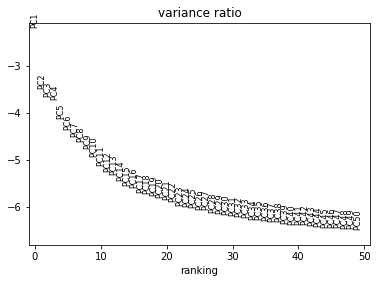

AnnData object with n_obs × n_vars = 2885 × 13779
    obs: 'coarseClusters', 'fineClusters', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'n_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
UMAPPING


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


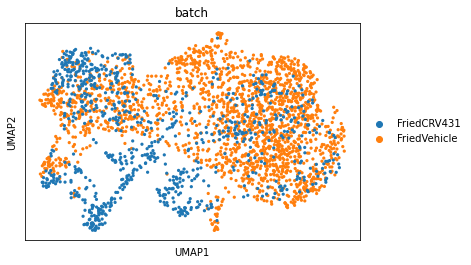

RANKING


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


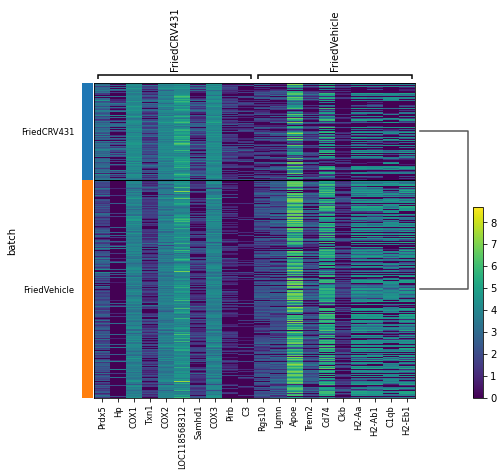

In [87]:
treat1='FriedVehicle'
treat2='FriedCRV431'
depth='coarse' #'macro', 'coarse', 'fine'
cellType='Monocytes'
doUMAP=True
print(np.unique(Data[treat2].obs[f'{depth}Clusters']))


adata = process.catAdata(Data, [treat1, treat2], obsKey=f"{depth}Clusters", obsVal=cellType, normReads=False, combat=False)
adata = adata[:,~adata.var_names.str.startswith(("Rps","Rpl"))]
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
print(adata.shape)
if doUMAP:
    print("PCA")
    preprocess.doPCA(adata)
    print(adata)
    print("UMAPPING")
    preprocess.umapify(adata, color='batch')
print("RANKING")
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon', use_raw=False, max_iter=2000, pts=False, use_rep='X')
sc.tl.dendrogram(adata, groupby='batch')
sc.pl.rank_genes_groups_heatmap(adata)
#sc.tl.rank_genes_groups(adata, 'batch', method='logreg', max_iter=2000, pts=True)

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


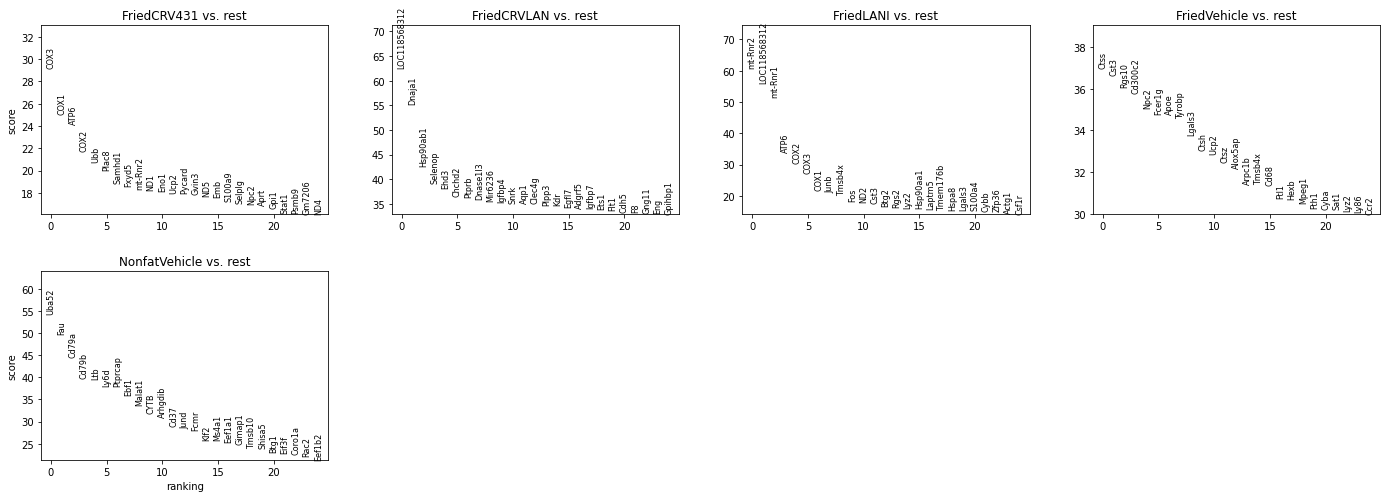

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


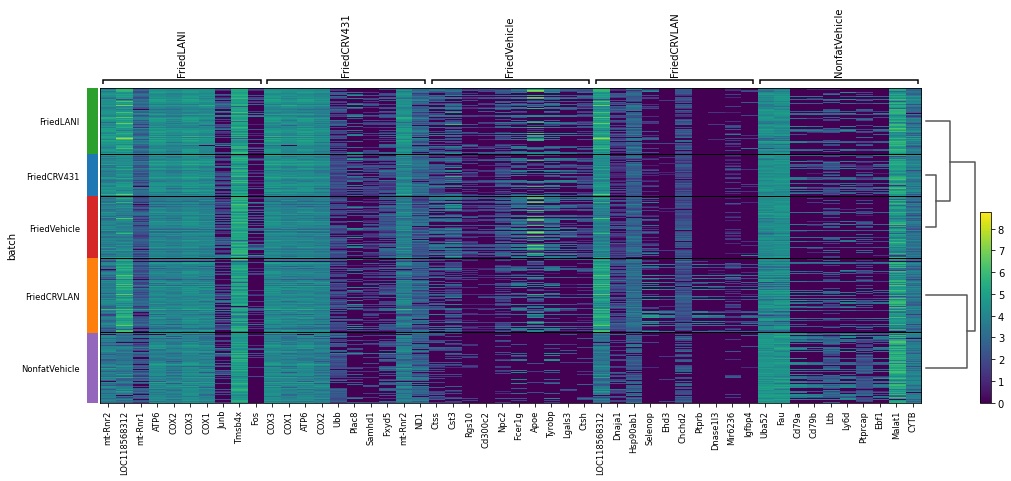

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame i

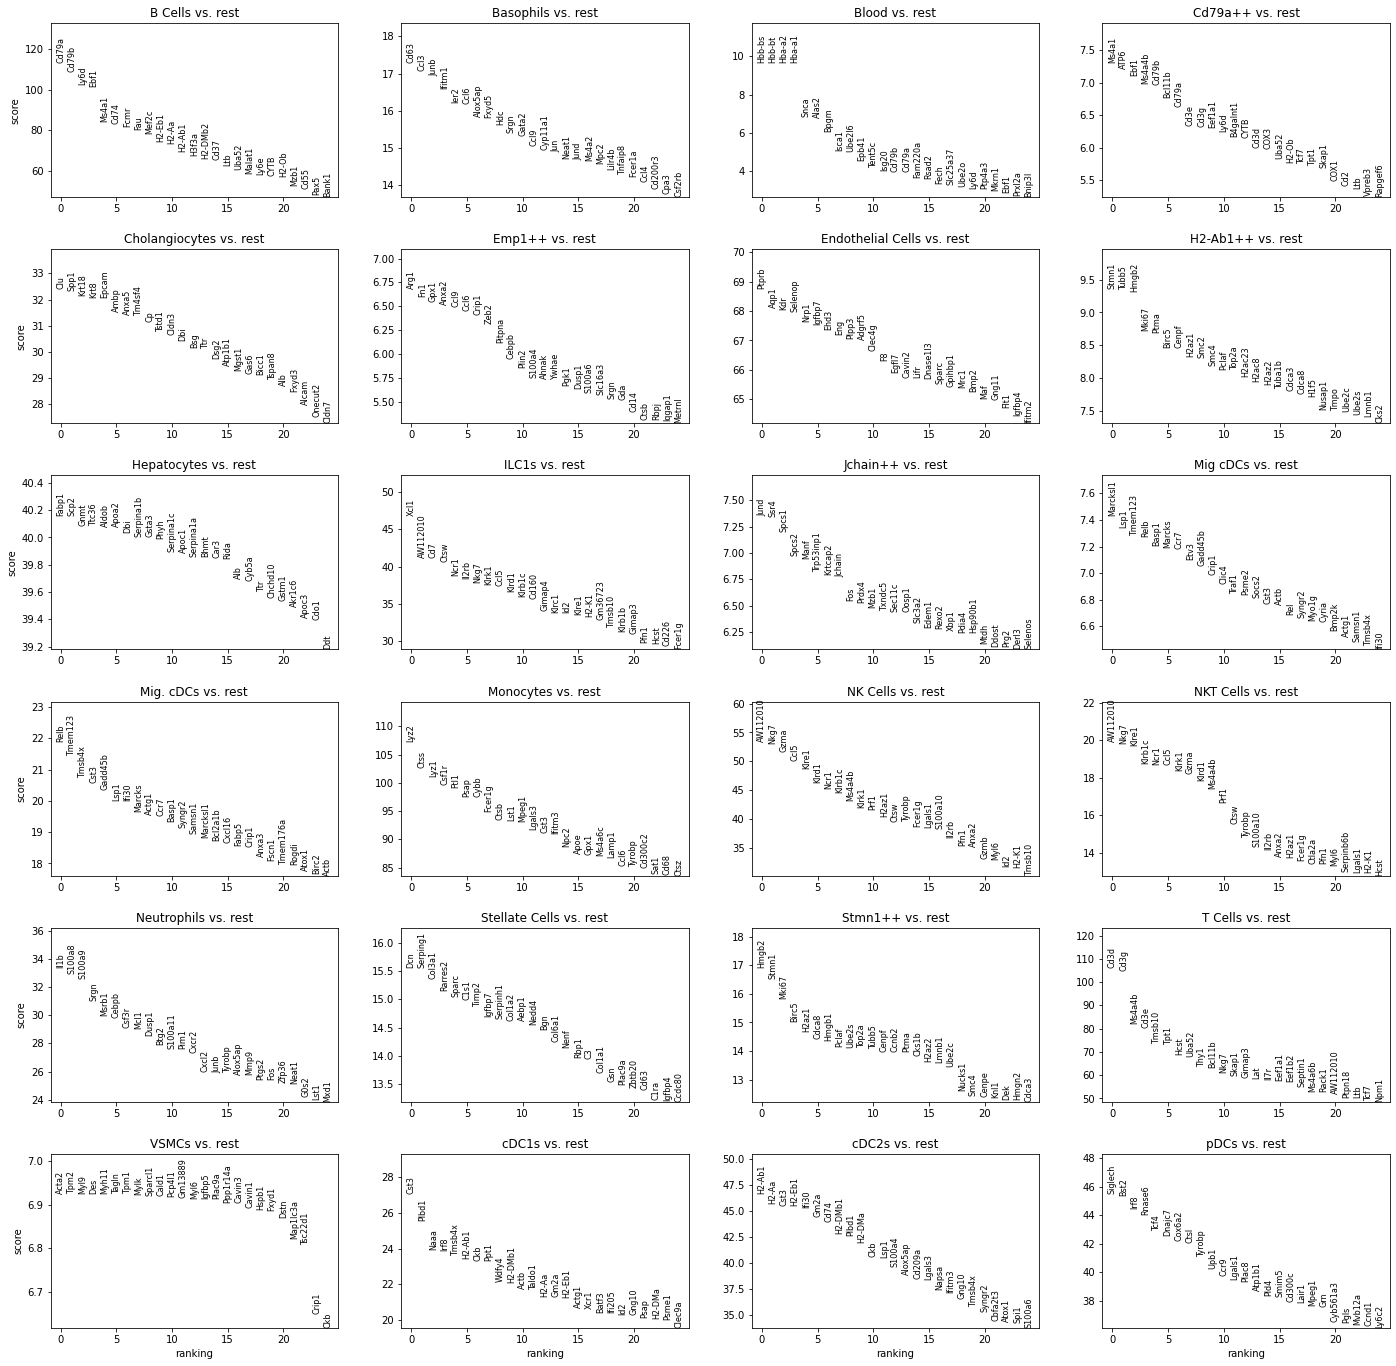

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


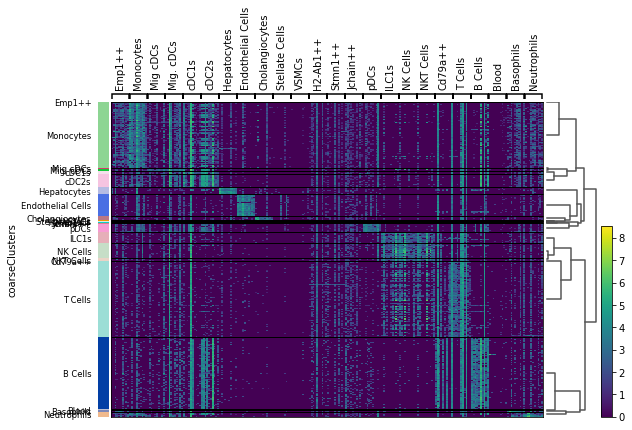

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


KeyboardInterrupt: 

In [73]:
### Dendrogram across all treatments
adata = process.catAdata(Data, treatments, normReads=False, combat=False)
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

#adata = adata[adata.obs['coarseClusters'] == 'Monocytes',:]
#adata.obs['coarseClusters'].value_counts()
adata = adata[:,~adata.var_names.str.startswith(("Rps","Rpl"))]

sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon', use_raw=False, max_iter=2000, pts=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.dendrogram(adata, groupby='batch')
sc.pl.rank_genes_groups_heatmap(adata)

sc.tl.rank_genes_groups(adata, 'coarseClusters', method='wilcoxon', use_raw=False, max_iter=2000, pts=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.dendrogram(adata, groupby='coarseClusters')
sc.pl.rank_genes_groups_heatmap(adata)

adata=adata[adata.obs['batch']!='NonfatVehicle']
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon', use_raw=False, max_iter=2000, pts=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.dendrogram(adata, groupby='batch')
sc.pl.rank_genes_groups_heatmap(adata)

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


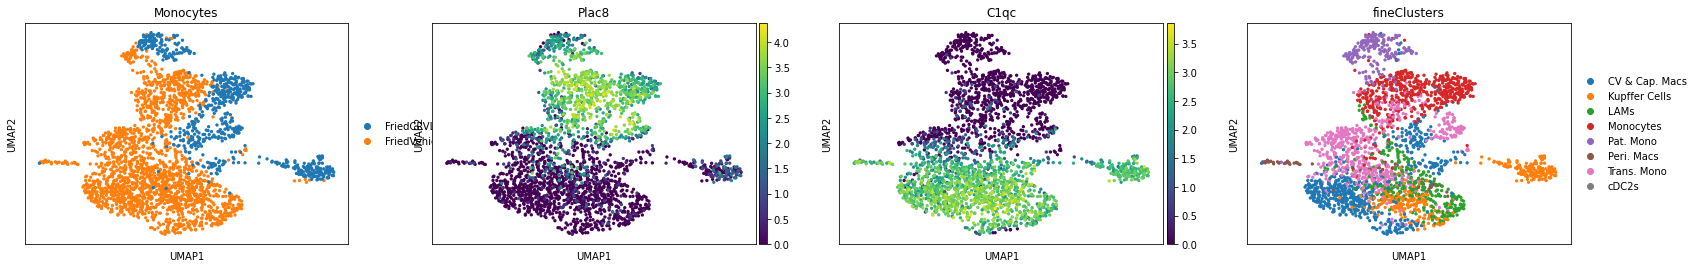

In [6]:
#preprocess.umapify(adata, color='fineClusters')
#sc.pl.umap(adata, color='fineClusters', title=cellType, legend_loc='on data')
sc.pl.umap(adata, color=['batch','Plac8','C1qc','fineClusters'], title=cellType)

In [18]:

print(adata.obs['batch'][-1])

dgeDF = process.tablize(adata, index=True, treatment=[treat1,treat2], cellType=cellType)

print(dgeDF[dgeDF['pvals_adj']<0.05].sort_values('pvals_adj').head(450))
#sc.pl.umap(adata, color=dgeDF[dgeDF['pvals_adj']<0.05].sort_values('pvals_adj').index, legend_loc='on data')

FriedCRVLAN
                         treatment baseTreatment contrastTreatment   cellType  \
Dntt    FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Tshz2   FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Ccr7    FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Cxcr2   FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Vpreb3  FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
...                            ...           ...               ...        ...   
Bhmt    FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
H2-Ob   FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Csf1    FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
H2ac8   FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   
Ehd3    FriedVehicle x FriedCRVLAN  FriedVehicle       FriedCRVLAN  Monocytes   

         genes 

In [38]:
print(list(adata.uns['rank_genes_groups'].keys()))

['params', 'pts', 'pts_rest', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']


FriedCRVLAN


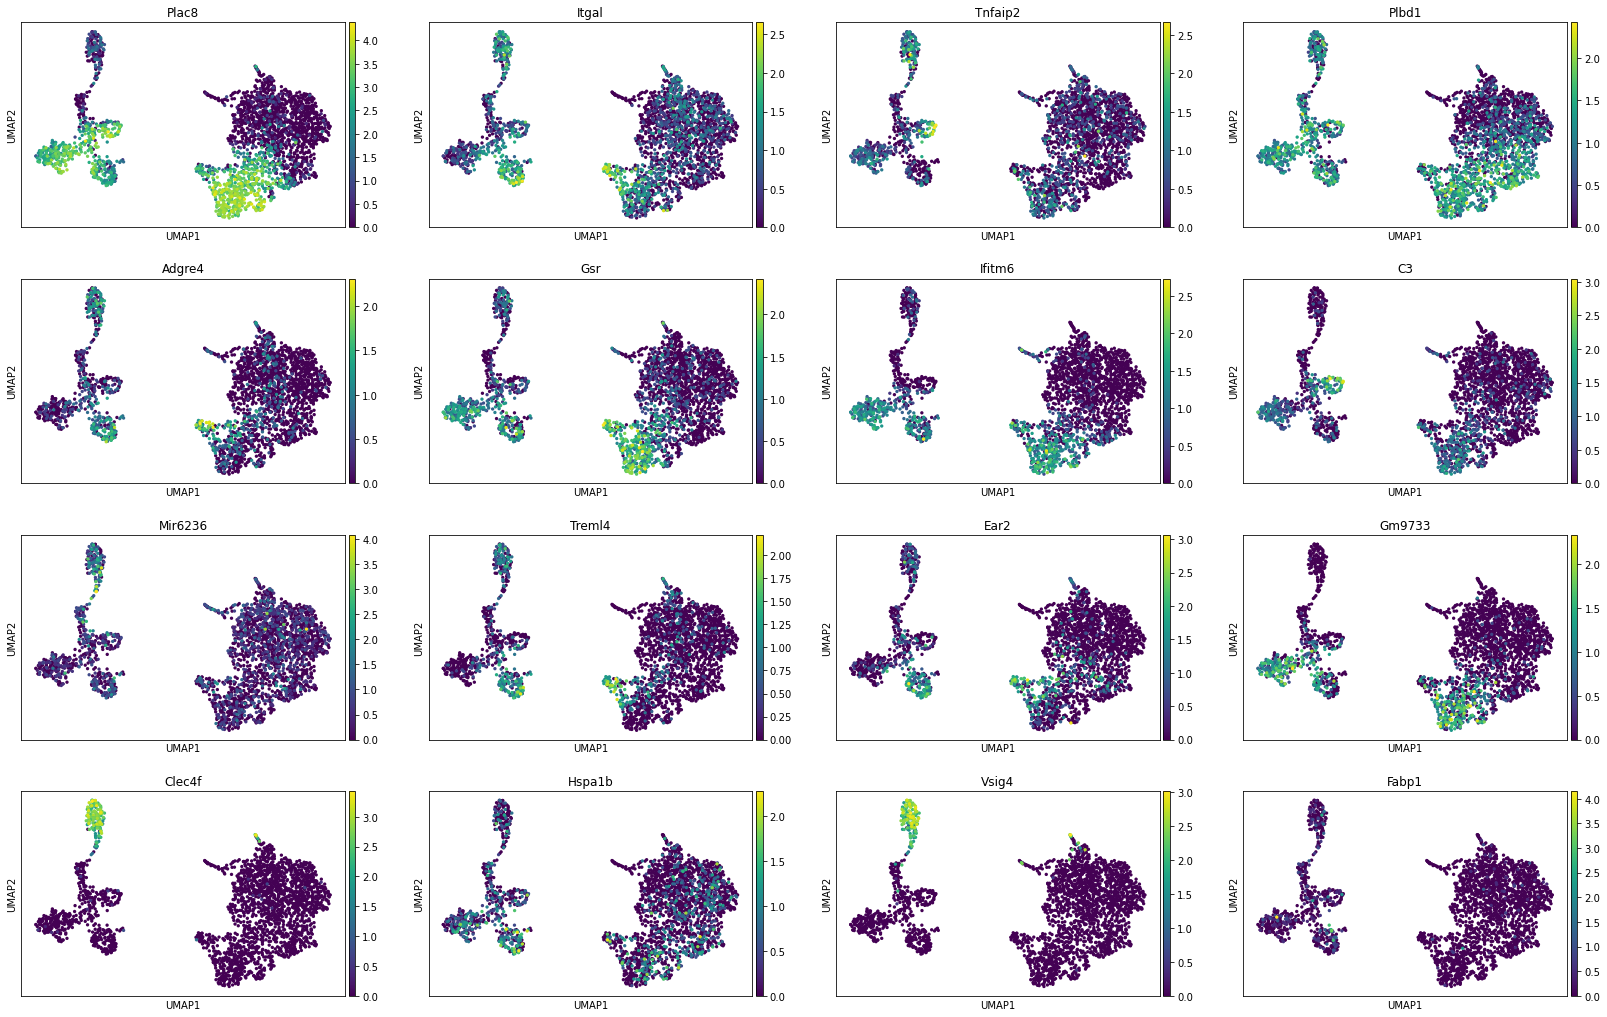

FriedVehicle


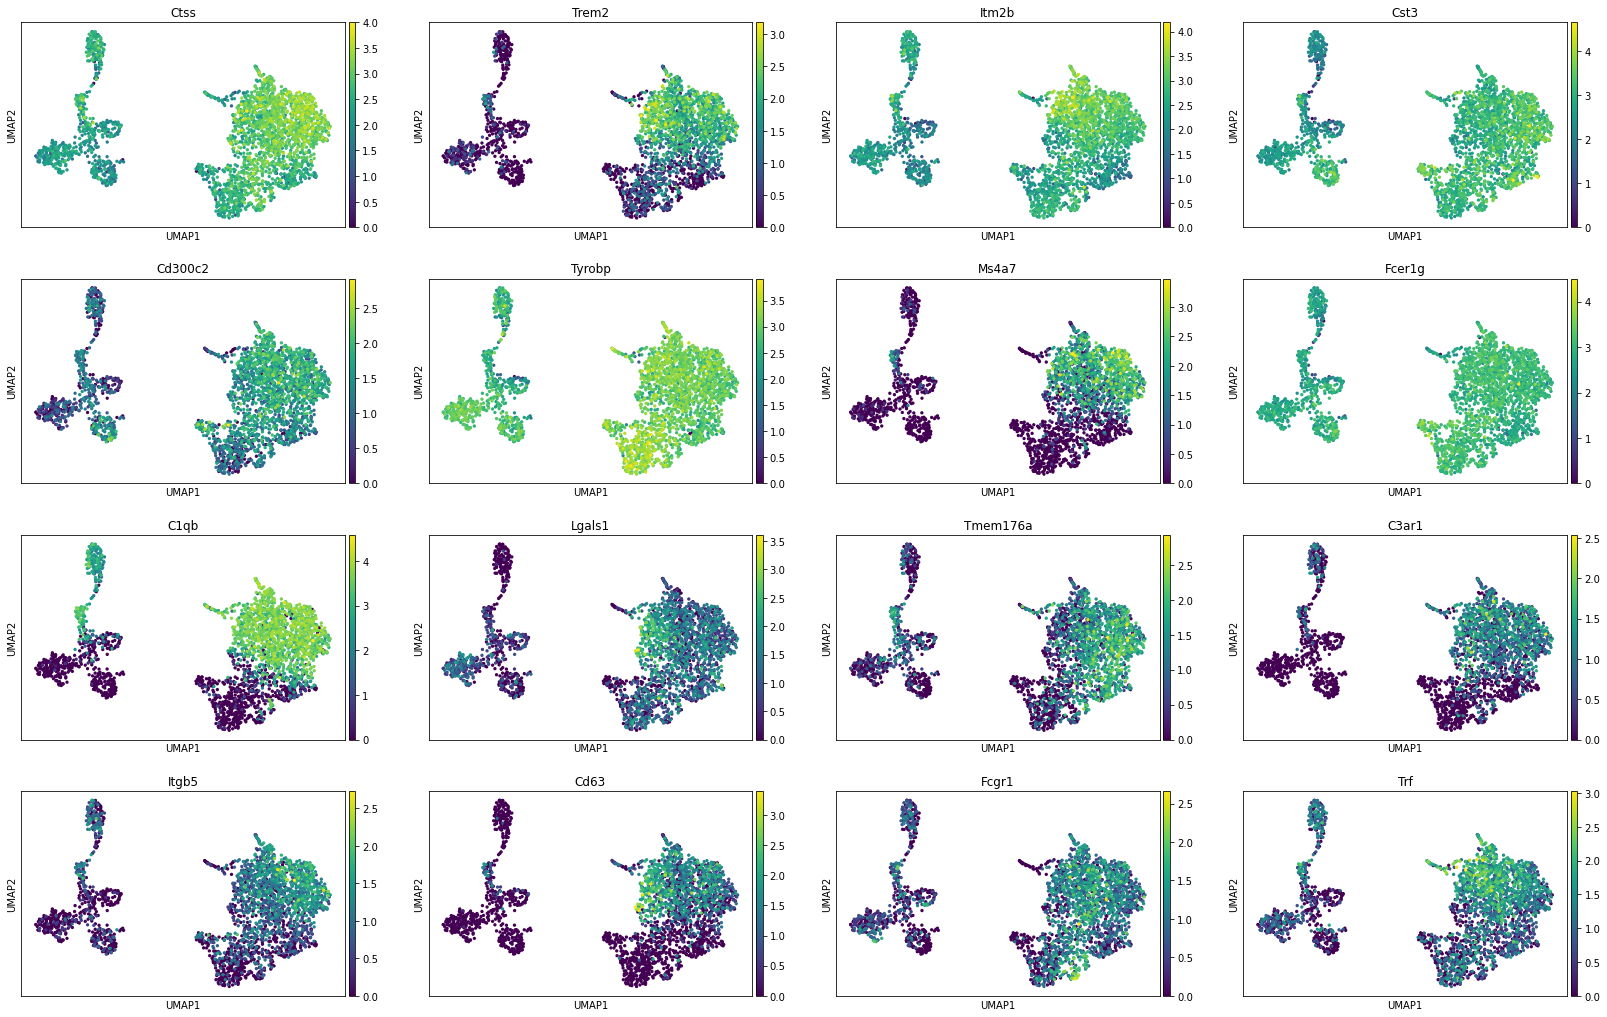

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


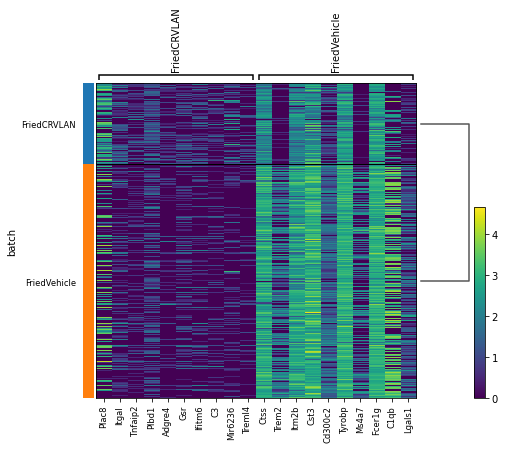

In [19]:
#sc.tl.rank_genes_groups(adata, 'batch', method='logreg', max_iter=2000)
#sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon')
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon', use_raw=Fals ]\
                        e, max_iter=2000, pts=False)'
sc.tl.umap(adata)
for val in np.unique(adata.obs['batch']):
    print(val)
    #print(adata.uns['rank_genes_groups'])
    sc.pl.umap(adata, color=adata.uns['rank_genes_groups']['names'][str(val)][:16])
sc.tl.dendrogram(adata, groupby='batch')
sc.pl.rank_genes_groups_heatmap(adata)
#sc.pl.umap(adata, color=['fineClusters', 'batch'])

In [6]:
### Make a df of all the dge results

coarseOrFine = 'fine'

t0=time.time()
combinedData = process.catAdata(Data, treatments, normReads=False, combat=False)
combinedData = process.dgeNorm(combinedData)

#combinedData = combinedData.raw.to_adata()
#sc.pp.normalize_total(combinedData)
#sc.pp.log1p(combinedData)
# ?
#sc.pp.scale(combinedData)
print(f"Norming Means Finished: {time.time()-t0}s")
'''
dfs=[]
for i, treat1 in enumerate(treatments):
    print(treat1)
    for j, treat2 in enumerate(treatments):
        if j>i:
            cellTypes = np.unique(Data[treat2].obs[f'{coarseOrFine}Clusters'])
            adata = combinedData[(combinedData.obs['batch']==treat1) | (combinedData.obs['batch']==treat2)]
            for celltype in cellTypes:
                if celltype in np.unique(Data[treat1].obs[f'{coarseOrFine}Clusters']):
                    print(f"{treat1} {treat2} {celltype}")
                    cellTypeAdata = adata[adata.obs[f"{coarseOrFine}Clusters"]==celltype]
                    sc.tl.rank_genes_groups(cellTypeAdata, 'batch', groups=[treat2], reference=treat1, use_raw=False, method='wilcoxon', max_iter=2000, pts=False)
                    dgeDF = process.tablize(cellTypeAdata, index=True, treatment=[treat1,treat2], cellType=celltype, counts=False)

                    dfs.append(dgeDF)
adata=None
totalDF = pd.concat(dfs, ignore_index=True)
'''
totalDF = process.doDGE(combinedData, treatments, obsKey = f'{coarseOrFine}Clusters')

print("\nFinished")


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Norming Means Finished: 7.7047600746154785s
NonfatVehicle
NonfatVehicle FriedVehicle B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Basophils
NonfatVehicle FriedVehicle CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle Peri. Macs
NonfatVehicle FriedVehicle Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedVehicle pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Basophils
NonfatVehicle FriedCRV431 CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRV431 Y-Delta T Cells
NonfatVehicle FriedCRV431 pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Basophils
NonfatVehicle FriedLANI CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Peri. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedLANI pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN Basophils
NonfatVehicle FriedCRVLAN CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN Neutrophils
NonfatVehicle FriedCRVLAN Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NonfatVehicle FriedCRVLAN pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle
FriedVehicle FriedCRV431 B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Basophils
FriedVehicle FriedCRV431 CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Cholangiocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Endothelial Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Mig. cDCs
FriedVehicle FriedCRV431 Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Stellate Cells
FriedVehicle FriedCRV431 Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 cDC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRV431 pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Basophils
FriedVehicle FriedLANI CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Cholangiocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Endothelial Cells
FriedVehicle FriedLANI Hepatocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Jchain++
FriedVehicle FriedLANI Kupffer Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Mig. cDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Peri. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Stellate Cells
FriedVehicle FriedLANI Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI cDC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedLANI pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Basophils
FriedVehicle FriedCRVLAN CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Cholangiocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Endothelial Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Hepatocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Kupffer Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Mig. cDCs
FriedVehicle FriedCRVLAN Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Stellate Cells
FriedVehicle FriedCRVLAN Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN cDC1s
FriedVehicle FriedCRVLAN cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedVehicle FriedCRVLAN pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431
FriedCRV431 FriedLANI B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Basophils
FriedCRV431 FriedLANI CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Cd79a++
FriedCRV431 FriedLANI Cholangiocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Endothelial Cells
FriedCRV431 FriedLANI ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Mig. cDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Stellate Cells
FriedCRV431 FriedLANI Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI cDC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedLANI pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Basophils
FriedCRV431 FriedCRVLAN CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Cholangiocytes
FriedCRV431 FriedCRVLAN Endothelial Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Mig. cDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Stellate Cells
FriedCRV431 FriedCRVLAN Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN Y-Delta T Cells
FriedCRV431 FriedCRVLAN cDC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRV431 FriedCRVLAN pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI
FriedLANI FriedCRVLAN B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Basophils
FriedLANI FriedCRVLAN CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN CV & Cap. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Cholangiocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Endothelial Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Hepatocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Kupffer Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN LAMs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Mig. cDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Pat. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Stellate Cells
FriedLANI FriedCRVLAN Stmn1++


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN TRegs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Trans. Mono


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN cDC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN cDC2s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedLANI FriedCRVLAN pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


FriedCRVLAN

Finished


In [12]:
print(totalDF)

                            treatment  baseTreatment contrastTreatment  \
0        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
1        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
2        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
3        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
4        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
...                               ...            ...               ...   
2323715       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN   
2323716       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN   
2323717       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN   
2323718       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN   
2323719       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN   

        cellType         genes     scores pvals pvals_adj logfoldchanges  
0        B Cells       mt-Rnr2  20.7

In [ ]:
### To do Scar-associated Macrophages if wanted
doSAMS = False
dfs=[]
if doSAMs and coarseOrFine=='fine':
    for i, treat1 in enumerate(treatments):
        print(treat1)
        for j, treat2 in enumerate(treatments):
            if j>i:
                adata = combinedData[(combinedData.obs['batch']==treat1) | (combinedData.obs['batch']==treat2)]
                adata = adata[(adata.obs['fineClusters']=='LAMs') | (adata.obs['fineClusters']=='CV & Cap. Macs')]
                sc.tl.rank_genes_groups(adata, 'batch', groups=[treat2], reference=treat1, use_raw=False, method='wilcoxon', max_iter=2000, pts=False)
                dgeDF = process.tablize(adata, index=True, treatment=[treat1,treat2], cellType='SAMs', counts=False)
                adata=None
                totalDF = pd.concat([totalDF,dgeDF], ignore_index=True)
                

In [7]:
### Add counts to DF
t0 = time.time()
depth='fine'
otherDF = totalDF

print("Normalizing")
combinedData = process.catAdata(Data, treatments, normReads=False, combat=False)
combinedData = process.dgeNorm(combinedData)
'''
for i,t in enumerate(treatments):
    print(f"\nOn treatment {t}")
    adata = combinedData[combinedData.obs['batch']==t]
    col=[]
    col2=[]
    
    arr=[]
    ### Create a matrix of mean gene expressions for all cell in a cellType
    ### Precomputing this speeds up data extraction significantly
    print("Calculating EXP")
    adata.X=np.expm1(adata.X)
    
    print("Making meanMatrixDF")
    for cluster in np.unique(otherDF['cellType']):
        if cluster in np.unique(adata.obs[f'{depth}Clusters']):
            arr.append(np.asarray(adata[adata.obs[f'{depth}Clusters']==cluster].X.mean(axis=0))[0])
        else:
            arr.append([np.nan]*otherDF.shape[1])
    meanMatrixDF = pd.DataFrame(arr, index=np.unique(otherDF['cellType']), columns=adata.var.index)
    #print(meanMatrixDF)
    
    print("Making cellMatrix")
    cellCounts=[]
    for cluster in np.unique(otherDF['cellType']):
        cellCounts.append(adata[adata.obs[f'{depth}Clusters']==cluster].shape[0])
    cellCountDF = pd.DataFrame(cellCounts, index=np.unique(otherDF['cellType']), columns=['cellCounts'])
    
    
    print("Appending reads to DF")
    for index, row in otherDF.iterrows():
        cluster = row['cellType']
        gene = row['genes']
        col.append(meanMatrixDF.loc[cluster, gene])
        col2.append(cellCountDF.loc[cluster,'cellCounts'])
        #col2.append(adata[adata.obs[f'{depth}Clusters']==cluster].shape[0])
    otherDF[t]=col
    otherDF[t+'_cells']=col2
    
    adata.X=np.log1p(adata.X)
    
cells = [t+'_cells' for t in treatments]
cols=otherDF.columns[:9].tolist()+ treatments + cells
otherDF = otherDF[cols]
'''
otherDF = process.addReadCounts(totalDF, combinedData, treatments, obsKey=f'{depth}Clusters')

print(otherDF)
t1 = time.time()
print(f"Total Time Elapsed: {t1-t0}")

Normalizing


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



On treatment NonfatVehicle
Calculating EXP
Making meanMatrixDF
Making cellMatrix
Appending reads to DF

On treatment FriedVehicle
Calculating EXP
Making meanMatrixDF
Making cellMatrix
Appending reads to DF

On treatment FriedCRV431
Calculating EXP
Making meanMatrixDF
Making cellMatrix
Appending reads to DF

On treatment FriedLANI
Calculating EXP
Making meanMatrixDF
Making cellMatrix
Appending reads to DF

On treatment FriedCRVLAN
Calculating EXP
Making meanMatrixDF
Making cellMatrix
Appending reads to DF
                            treatment  baseTreatment contrastTreatment  \
0        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
1        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
2        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
3        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
4        NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle   
...                               ...        

In [17]:
#print(Data['FriedVehicle'][Data['FriedVehicle'].obs['coarseClusters']=='B Cells'][:,'COX3'].X)
print(outputDF[f'{outputDF["baseTreatment"]}_AvgReadsPerCell'])
print(outputDF[outputDF['contrastTreatment'].values])

KeyError: '0          NonfatVehicle\n1          NonfatVehicle\n2          NonfatVehicle\n3          NonfatVehicle\n5          NonfatVehicle\n               ...      \n2323710        FriedLANI\n2323711        FriedLANI\n2323717        FriedLANI\n2323718        FriedLANI\n2323719        FriedLANI\nName: baseTreatment, Length: 45241, dtype: object_AvgReadsPerCell'

In [12]:
print("Filter 1")
outputDF = otherDF[otherDF.pvals<=0.05]
print("Filter 2")
outputDF = outputDF[np.abs(outputDF.logfoldchanges)>0.75]
for i,t in enumerate(treatments):
    print(f'Filter {i+3}')
    avgMask=(outputDF[t+'_AvgReadsPerCell']>0)
    mask = (outputDF['baseTreatment'] != t)
    outputDF = outputDF[(mask)|(avgMask)]
    mask = (outputDF['contrastTreatment'] != t)
    outputDF = outputDF[(mask)|(avgMask)]
    
print("Making Spreadsheet")
out.makeSpreadsheet(outputDF, filename=f"{depth}DGE_results.xlsx", sheetKey='cellType', sortKey='pvals_adj')



Filter 1
Filter 2
Filter 3
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: NonfatVehicle_AvgReadsPerCell, Length: 45241, dtype: bool
0          False
1          False
2          False
3          False
5          False
           ...  
2323710     True
2323711     True
2323717     True
2323718     True
2323719     True
Name: baseTreatment, Length: 45241, dtype: bool
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: contrastTreatment, Length: 44918, dtype: bool
Filter 4
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: FriedVehicle_AvgReadsPerCell, Length: 44918, dtype: bool
0          True
1     

<ipython-input-12-05e39e4cf7ef>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outputDF = outputDF[(mask)|(avgMask)]
<ipython-input-12-05e39e4cf7ef>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outputDF = outputDF[(mask)|(avgMask)]
<ipython-input-12-05e39e4cf7ef>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outputDF = outputDF[(mask)|(avgMask)]


Filter 5
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: FriedCRV431_AvgReadsPerCell, Length: 44850, dtype: bool
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: baseTreatment, Length: 44850, dtype: bool
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: contrastTreatment, Length: 44807, dtype: bool
Filter 6
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: FriedLANI_AvgReadsPerCell, Length: 44773, dtype: bool
0           True
1           True
2           True
3    

<ipython-input-12-05e39e4cf7ef>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outputDF = outputDF[(mask)|(avgMask)]


Filter 7
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: FriedCRVLAN_AvgReadsPerCell, Length: 44615, dtype: bool
0          True
1          True
2          True
3          True
5          True
           ... 
2323710    True
2323711    True
2323717    True
2323718    True
2323719    True
Name: baseTreatment, Length: 44615, dtype: bool
0           True
1           True
2           True
3           True
5           True
           ...  
2323710    False
2323711    False
2323717    False
2323718    False
2323719    False
Name: contrastTreatment, Length: 44615, dtype: bool
Making Spreadsheet
On B Cells
On Basophils
On CTLs
On CV & Cap. Macs
On Cd79a++
On Cholangiocytes
On Endothelial Cells
On Hepatocytes
On ILC1s
On Jchain++
On Kupffer Cells
On LAMs
On Mig. cDCs
On Monocytes
On NK Cells
On Naive CD4+
On Naive CD8+
On Neutrophils
On Pat. Mono
On Peri. Macs
On

In [2]:
### Load Previous DGE DF
#path = f"{depth}DGE_results.xlsx"
path = "fineDGE_results.xlsx"
dgeDF = pd.read_excel(path)
print(dgeDF)

In [4]:
otherDF = dgeDF
print(otherDF)

                          treatment  baseTreatment contrastTreatment cellType  \
0      NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle  B Cells   
1      NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle  B Cells   
2      NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle  B Cells   
3      NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle  B Cells   
4      NonfatVehicle x FriedVehicle  NonfatVehicle      FriedVehicle  B Cells   
...                             ...            ...               ...      ...   
44455       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN     pDCs   
44456       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN     pDCs   
44457       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN     pDCs   
44458       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN     pDCs   
44459       FriedLANI x FriedCRVLAN      FriedLANI       FriedCRVLAN     pDCs   

              genes     sco

In [18]:
### Count number of DEGs by cellType
def numDEGs(DGEDF, t1, t2, cellTypes=None, doFilter=True):
    print(f"\n{t1} x {t2}")
    if doFilter:
        sigDF = DGEDF[DGEDF.pvals<=0.1]
        sigDF = sigDF[np.abs(sigDF.logfoldchanges)>1.0]
        sigDF = sigDF[sigDF['baseTreatment'] == t1]
        sigDF = sigDF[sigDF['contrastTreatment'] == t2]
        for i,t in enumerate(treatments):
            avgMask=(sigDF[t+'_AvgReadsPerCell']>0)
            mask = (sigDF['baseTreatment'] != t)
            sigDF = sigDF[(mask)|(avgMask)]
            mask = (sigDF['contrastTreatment'] != t)
            sigDF = sigDF[(mask)|(avgMask)]
    l = []
    for cellType in cellTypes:
        numDEGs = sigDF[sigDF['cellType']==cellType].shape[0]
        l.append(numDEGs)
    return l


gdf = pd.DataFrame(index=np.unique(otherDF['cellType']))
for i, t1 in enumerate(treatments):
    for j, t2 in enumerate(treatments):
        if i<j:
            DEGNumbers = process.numDEGs(otherDF, t1,t2, cellTypeList = np.unique(otherDF['cellType']))
            #DEGNumbers=numDEGs(otherDF, t1,t2, cellTypes = np.unique(otherDF['cellType']))
            gdf[f'{t1} x {t2} DEGs'] = DEGNumbers
#numDEGs()
print(gdf)
#gdf.to_csv("DEGs_per_treatment.csv")


NonfatVehicle x FriedVehicle

NonfatVehicle x FriedCRV431

NonfatVehicle x FriedLANI

NonfatVehicle x FriedCRVLAN

FriedVehicle x FriedCRV431

FriedVehicle x FriedLANI

FriedVehicle x FriedCRVLAN

FriedCRV431 x FriedLANI

FriedCRV431 x FriedCRVLAN

FriedLANI x FriedCRVLAN
                   NonfatVehicle x FriedVehicle DEGs  \
B Cells                                           59   
Basophils                                        236   
CTLs                                              90   
CV & Cap. Macs                                     0   
Cd79a++                                            0   
Cholangiocytes                                     0   
Endothelial Cells                                  0   
Hepatocytes                                        0   
ILC1s                                             39   
Jchain++                                           0   
Kupffer Cells                                      0   
LAMs                                               0  

/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


NonfatVehicle x FriedVehicle


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9209697604080266


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


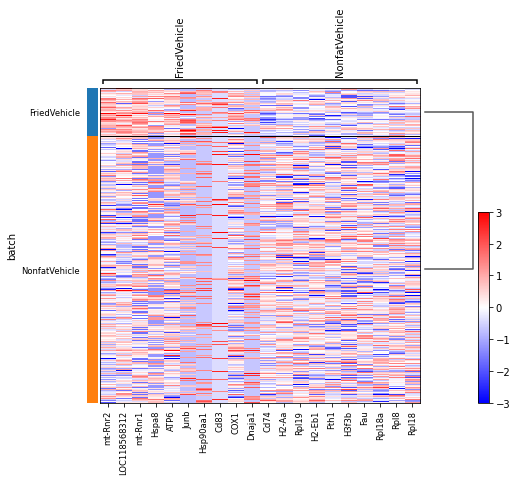

Basophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.858509464567301


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


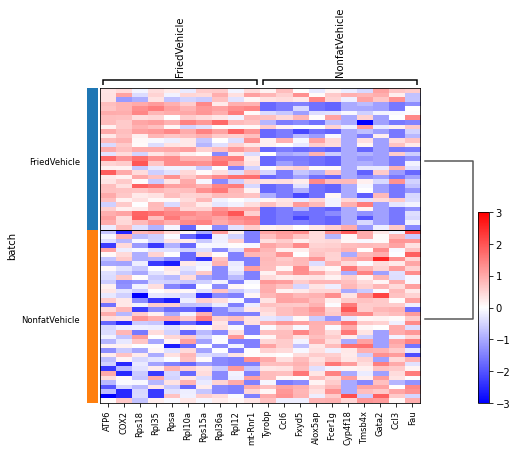

Blood
CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9394100795245002


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


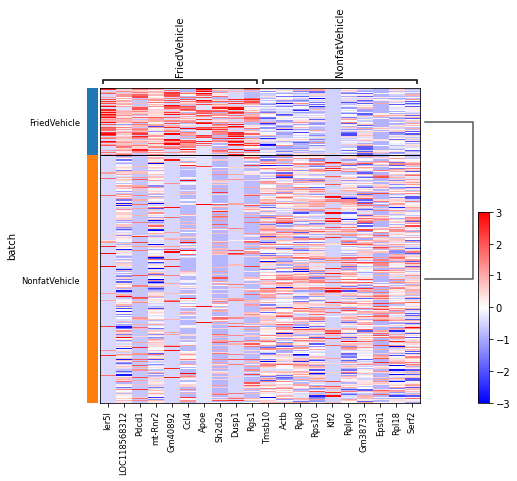

CV & Cap. Macs
Cd79a++
Cholangiocytes
Ebf1++
Emp1++
Endothelial Cells
H2-Ab1++
Hepatocytes
ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9576937863810238


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


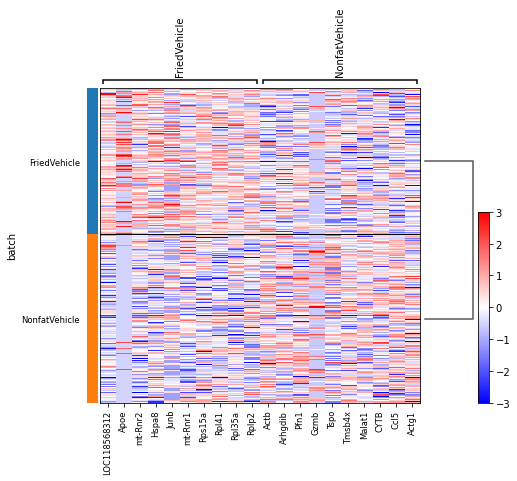

Jchain++
Kupffer Cells
LAMs
Mig. cDCs
Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.42833905057707944


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


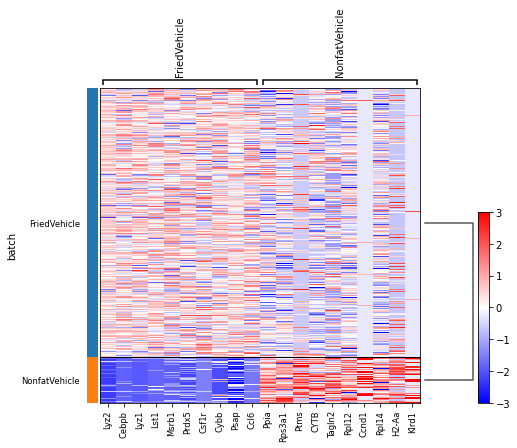

NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9540233468232855


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


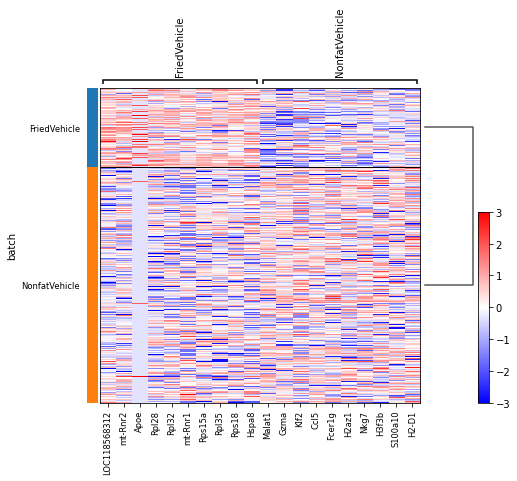

NKT Cells
Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9745607064444735


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


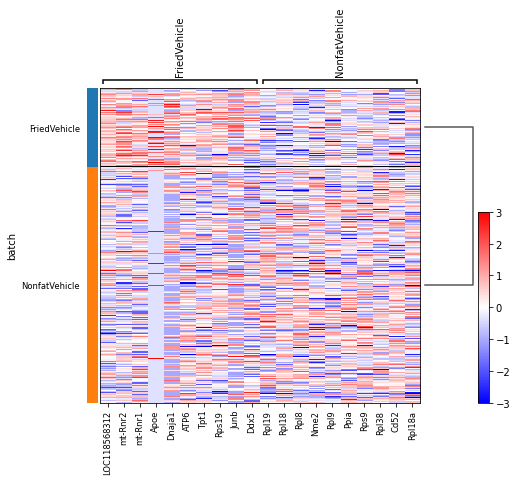

Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9403819719609912


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


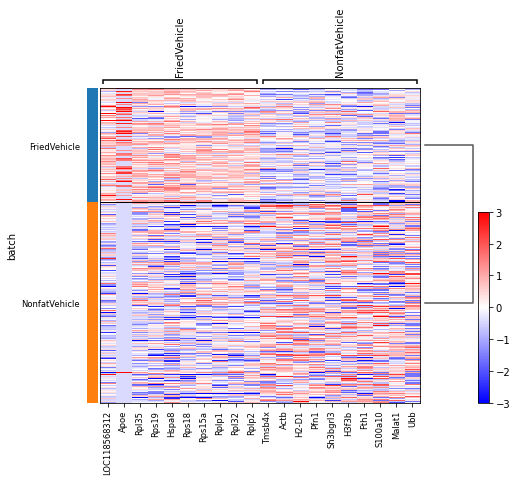

Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9516498104105382


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


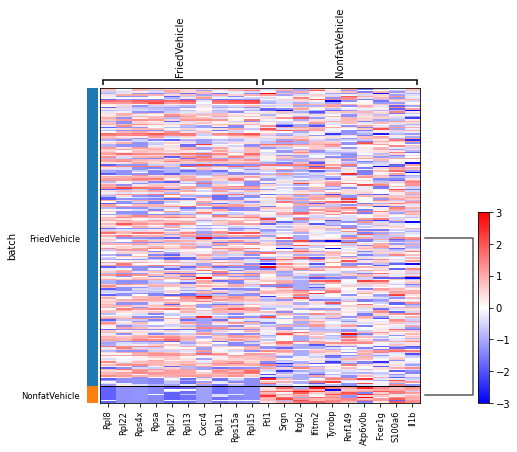

Pat. Mono
Peri. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.79943744402889


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


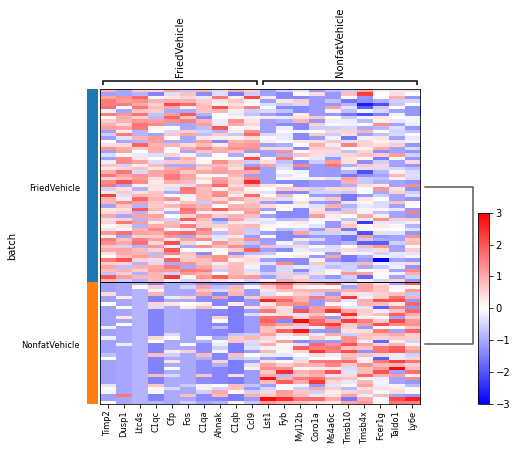

Stellate Cells
Stmn1++
TEM
TRegs
Th1s
Trans. Mono
VSMCs
Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.955200569852147


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


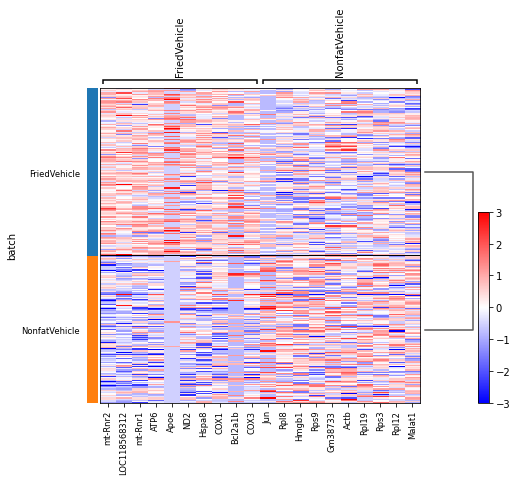

cDC1s
cDC2s
pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9858020918463315


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


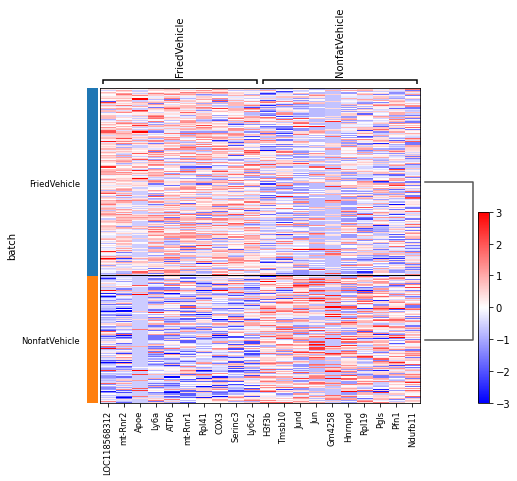

NonfatVehicle x FriedCRV431


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8185541177153965


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


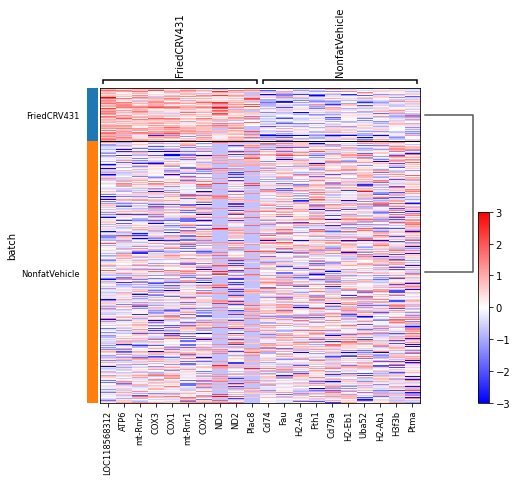

Basophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9681890191930401


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


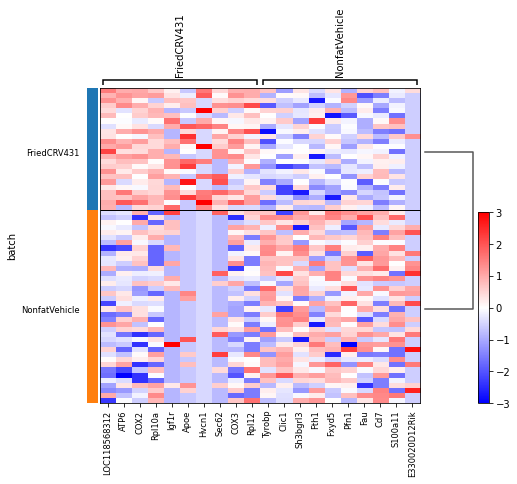

Blood
CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8446784952834635


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


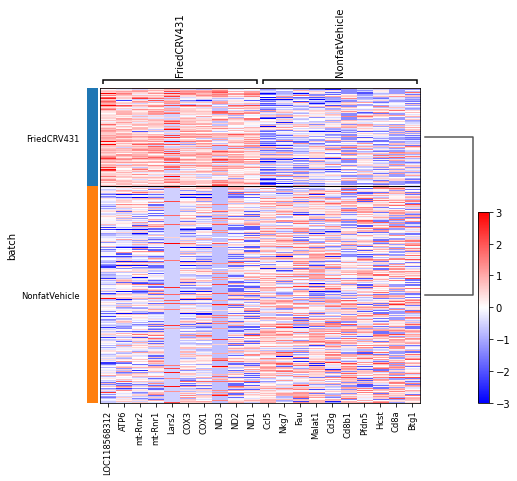

CV & Cap. Macs
Cd79a++
Cholangiocytes
Ebf1++
Emp1++
Endothelial Cells
H2-Ab1++
Hepatocytes
ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9617767529681184


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


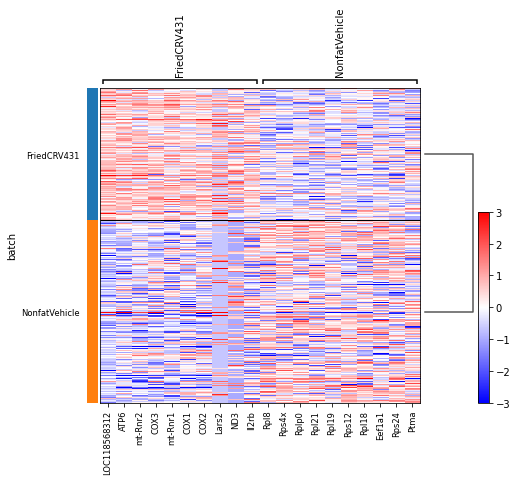

Jchain++
Kupffer Cells
LAMs
Mig. cDCs
Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.5050987734028436


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


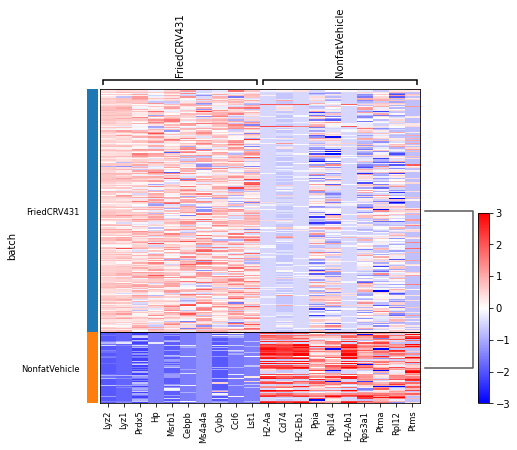

NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9030972891548116


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


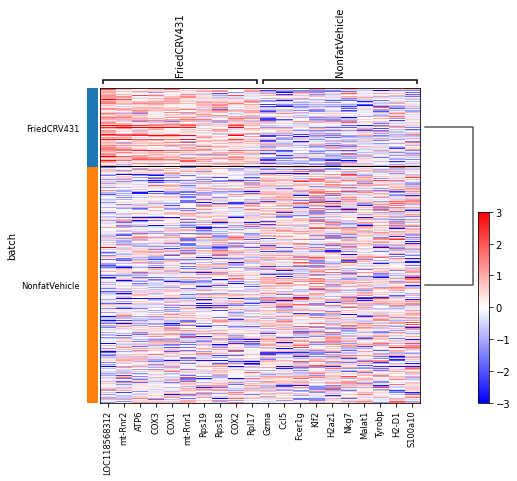

NKT Cells
Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9403316908406347


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


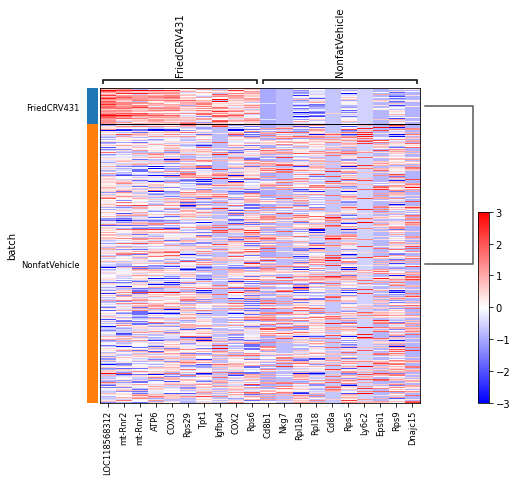

Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.7803913992585064


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


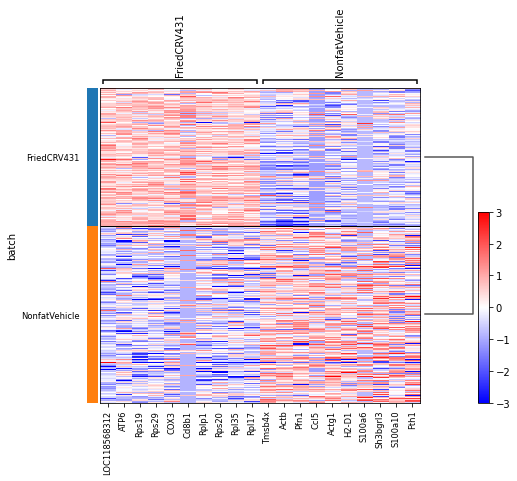

Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9393834292151335


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


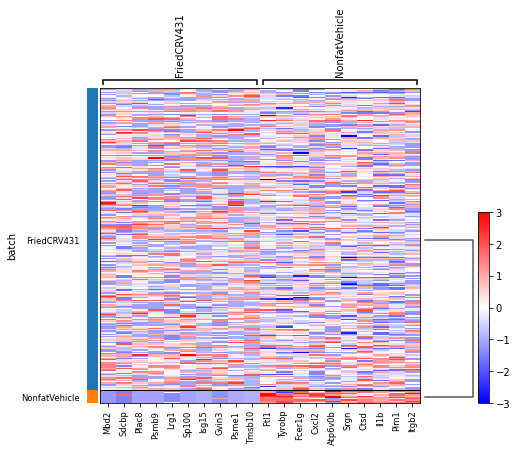

Pat. Mono
Peri. Macs
Stellate Cells
Stmn1++
TEM
TRegs
Th1s
Trans. Mono
VSMCs
Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9384983324530448


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


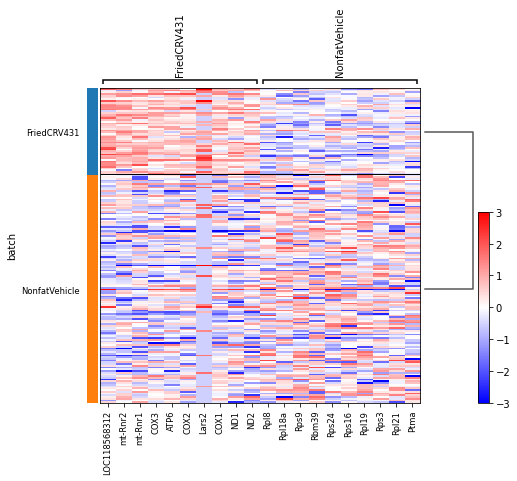

cDC1s
cDC2s
pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9821893342624481


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


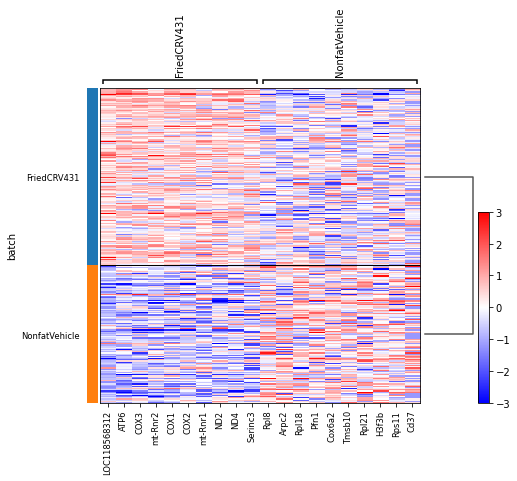

NonfatVehicle x FriedLANI


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8722447786616175


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


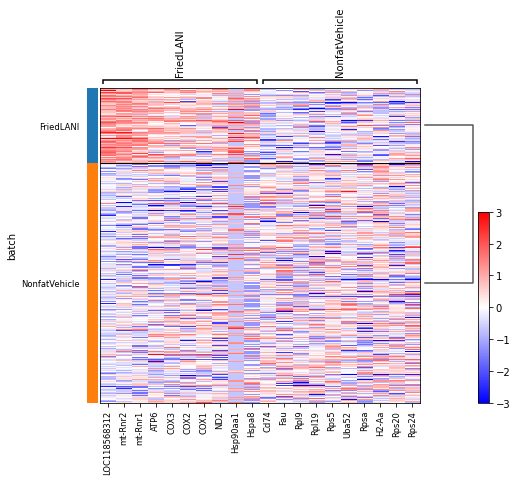

Basophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9625575145966614


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


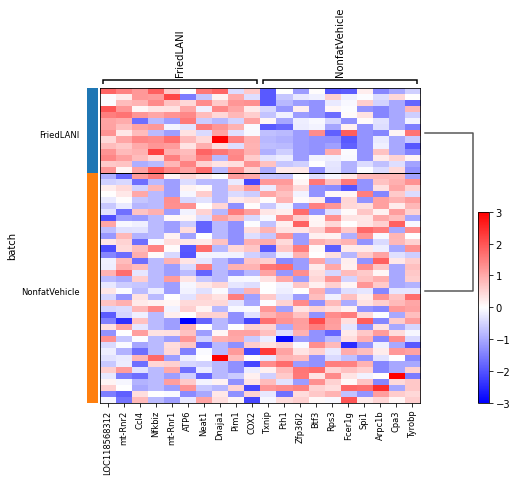

Blood
CTLs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8918910732176693


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


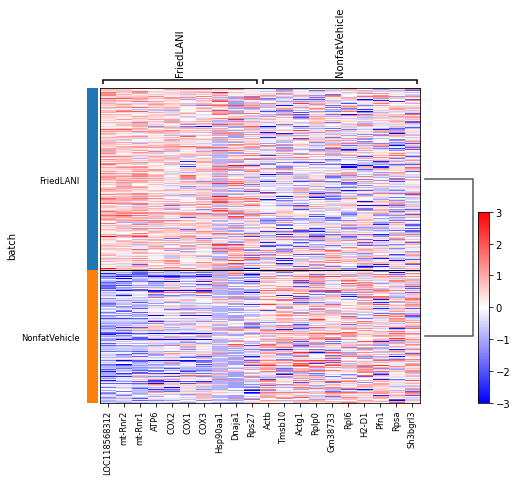

CV & Cap. Macs
Cd79a++
Cholangiocytes
Ebf1++
Emp1++
Endothelial Cells
H2-Ab1++
Hepatocytes
ILC1s


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9173332121012479


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


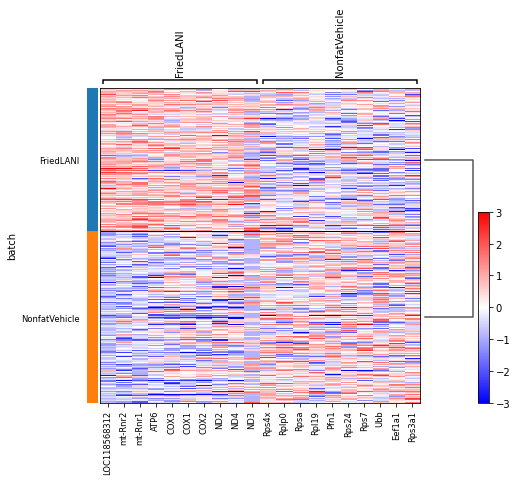

Jchain++
Kupffer Cells
LAMs
Mig. cDCs
Monocytes


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.44602962583865446


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


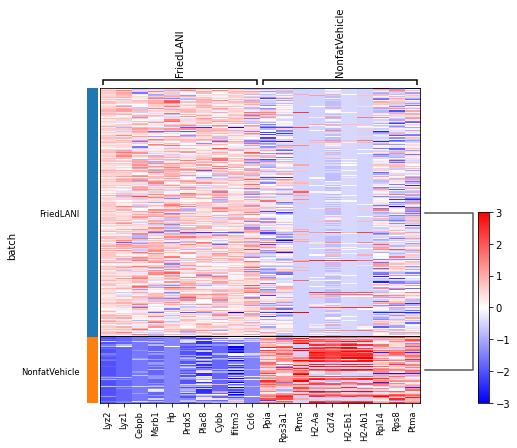

NK Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9464996371090655


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


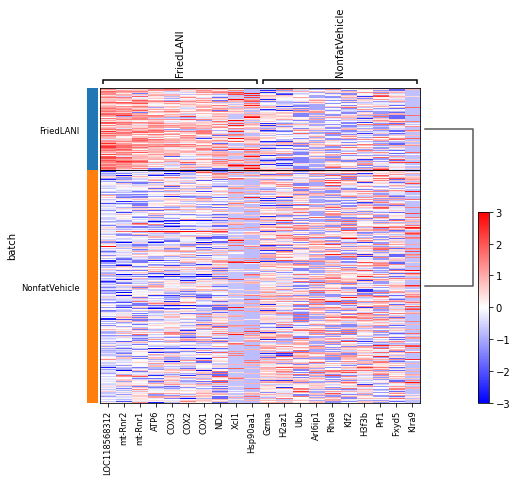

NKT Cells
Naive CD4+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9201651005397284


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


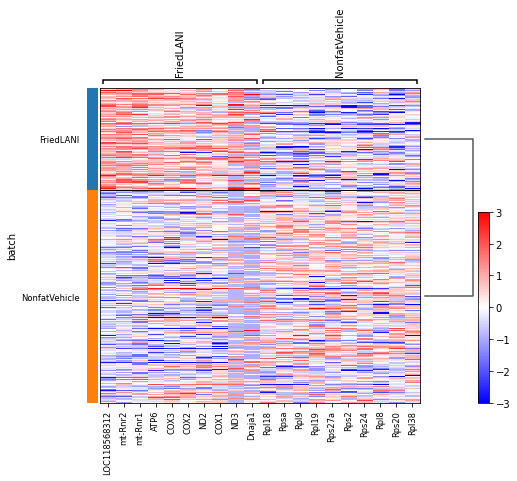

Naive CD8+


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8878850949245132


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


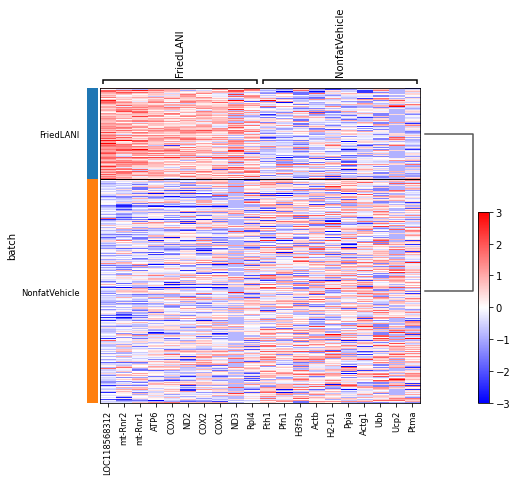

Neutrophils


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9848659051956479


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


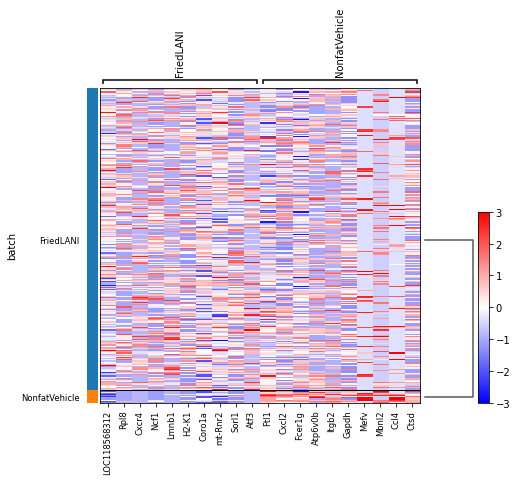

Pat. Mono
Peri. Macs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.7506705531221876


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


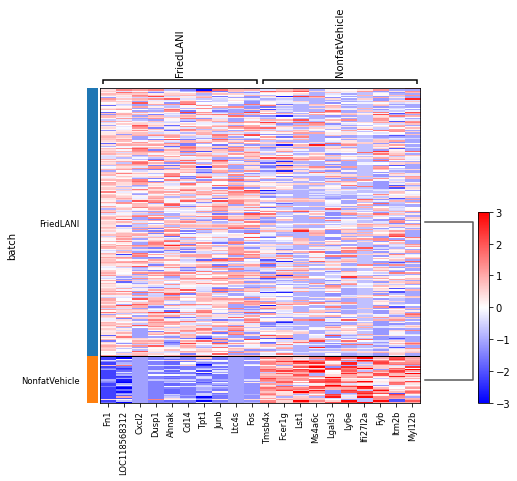

Stellate Cells
Stmn1++
TEM
TRegs
Th1s
Trans. Mono
VSMCs
Y-Delta T Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.8880670956518711


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


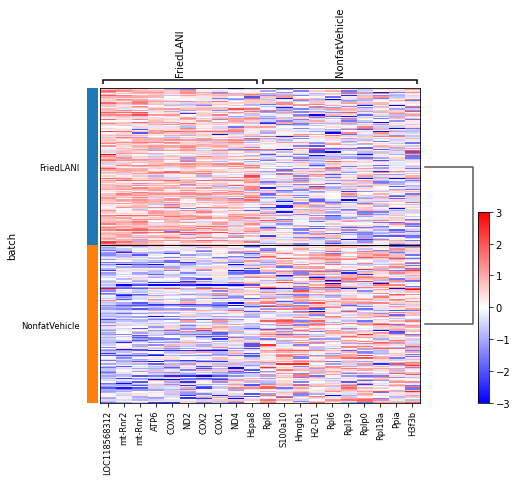

cDC1s
cDC2s
pDCs


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.9599060398069884


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


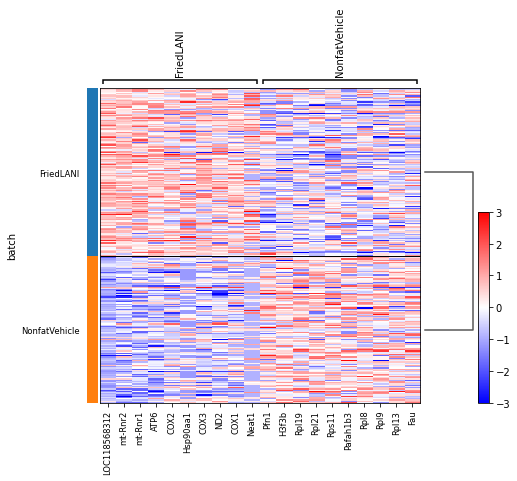

NonfatVehicle x FriedCRVLAN


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


B Cells


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


KeyboardInterrupt: 

In [3]:
treatment = ['NonfatVehicle', 'FriedVehicle', 'FriedCRV431', 'FriedLANI', 'FriedCRVLAN']
mtxPath = "/Volumes/Expansion/Hepion/Data/"
tempData = {t:input.loadSTAR(f"{mtxPath}{t}/", labels=True, make_unique=False) for t in treatment}
treatmentSimilarityDF = out.rankCellTypes(tempData, treatment, heatmap=True, silent=False)
tempData=None
print(treatmentSimilarityDF)


In [24]:
mtxPath = "/Volumes/Expansion/Hepion/Data/"
theTs = ['FriedVehicle', 'FriedCRV431']
miData = {t:input.loadSTAR(f"{mtxPath}{t}/", labels=True, make_unique=False) for t in theTs}


heatData = process.catAdata(miData, theTs)
forbidden=['Cd79a++', 'Emp1++','Jchain++', 'Ebf1++']
for ct in forbidden:
    heatData = heatData[heatData.obs['coarseClusters']!=ct]
sc.pp.highly_variable_genes(heatData, n_top_genes=3000, flavor='seurat_v3')
heatData = heatData[:,heatData.var.highly_variable]
heatData = process.dgeNorm(heatData, useRaw=False, scale=True, pca=True)
print("Ranking Gene Groups")
#sc.tl.rank_genes_groups(heatData, 'batch', method='wilcoxon', use_raw=False, max_iter=2000, pts=False, cor_method='spearman')
print('Ranking Gene Groups2')
#sc.tl.rank_genes_groups(heatData, 'fineClusters', method='wilcoxon', use_raw=False, max_iter=2000, pts=False,n_genes=30, cor_method='pearson')
sc.tl.rank_genes_groups(heatData, 'coarseClusters', method='t-test', n_genes=30, cor_method='pearson')
#sc.tl.rank_genes_groups(heatData, 'fineClusters', method='wilcoxon', n_genes=30, cor_method='pearson')
#sc.tl.dendrogram(heatData, groupby='batch', )
print("finished")



/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Ranking Gene Groups
Ranking Gene Groups2
finished


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [23]:
print(heatData)
#print(np.unique(heatData.obs['coarseClusters']))
#forbidden=['Cd79a++', 'Emp1++','Jchain++']
#print(heatData.obs['coarseClusters']!='')

AnnData object with n_obs × n_vars = 8359 × 3000
    obs: 'coarseClusters', 'fineClusters', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'rank_genes_groups', 'batch_colors', 'dendrogram_batch', 'dendrogram_batch_fineClusters'
    obsm: 'X_pca'
    varm: 'PCs'


categories: FriedCRV431, FriedVehicle
var_group_labels: B Cells, Basophils, Cholangiocytes, etc.


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


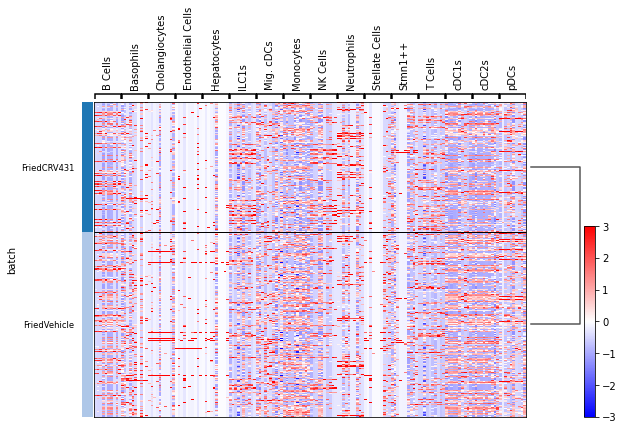

In [26]:
#draw.heatmapper(heatData, groupby=['batch','fineClusters'])
draw.heatmapper(heatData, groupby=['batch'])

In [25]:
### Combines cluster correlations w # of DEGs
combinedDF = pd.merge(treatmentSimilarityDF, gdf, left_index=True, right_index=True,how='right')
combinedDF = combinedDF.reindex(sorted(combinedDF.columns), axis=1)
print(combinedDF)

combinedDF.to_csv("cluster_similarity_scores.csv")

                  FriedCRV431 x FriedCRVLAN  FriedCRV431 x FriedCRVLAN DEGs  \
B Cells                            0.936365                              81   
Basophils                          0.978569                              60   
CTLs                               0.900868                             150   
CV & Cap. Macs                     0.789308                             350   
Cd79a++                                None                               0   
Cholangiocytes                     0.983594                              91   
Endothelial Cells                  0.929717                             139   
Hepatocytes                            None                               0   
ILC1s                              0.946185                              90   
Jchain++                               None                               0   
Kupffer Cells                          None                               0   
LAMs                               0.615525         


NonfatVehicle x FriedVehicle


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['B Cells' 'Basophils' 'CTLs' 'CV & Cap. Macs' 'Cholangiocytes' 'Ebf1++'
 'Emp1++' 'Endothelial Cells' 'Hepatocytes' 'ILC1s' 'Jchain++'
 'Kupffer Cells' 'LAMs' 'Mig. cDCs' 'Monocytes' 'NK Cells' 'Naive CD4+'
 'Naive CD8+' 'Neutrophils' 'Pat. Mono' 'Peri. Macs' 'Stellate Cells'
 'Stmn1++' 'TEM' 'TRegs' 'Trans. Mono' 'Y-Delta T Cells' 'cDC1s' 'cDC2s'
 'pDCs']
B Cells
267
42


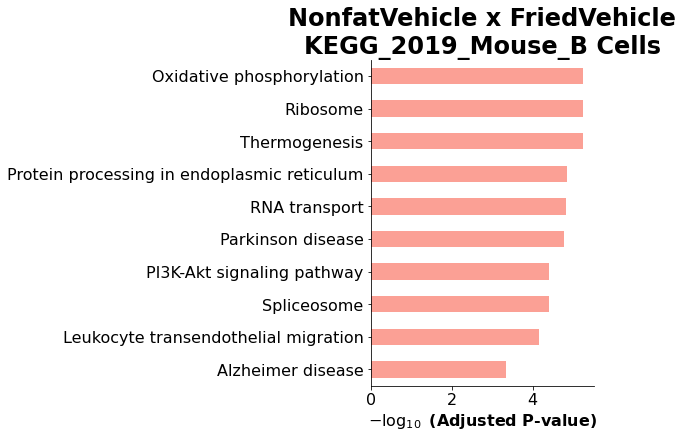

Basophils
4
8


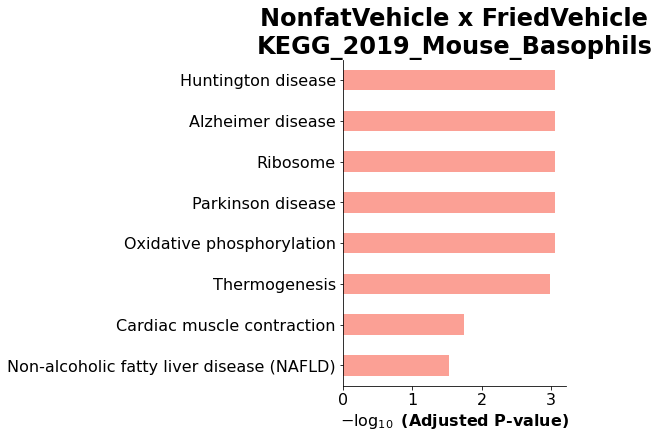

CTLs
18
1


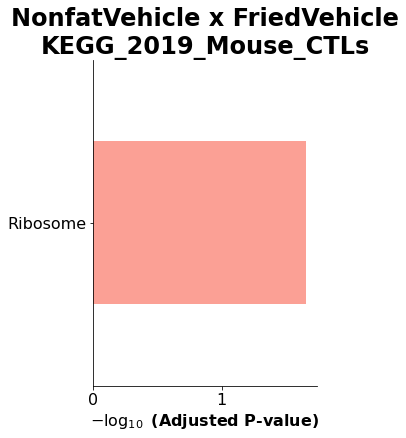

ILC1s
18
19


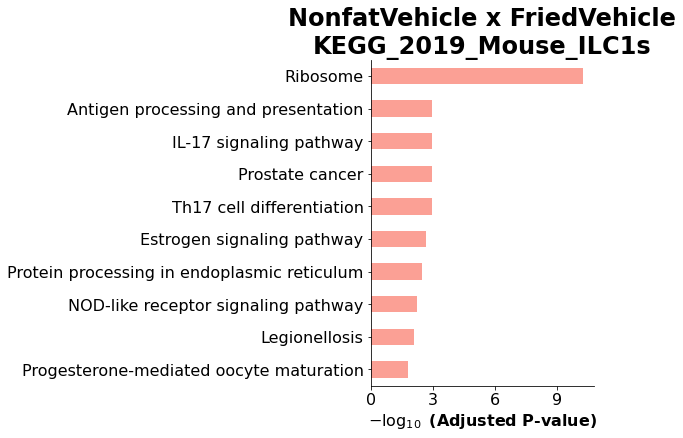

Monocytes
337
62


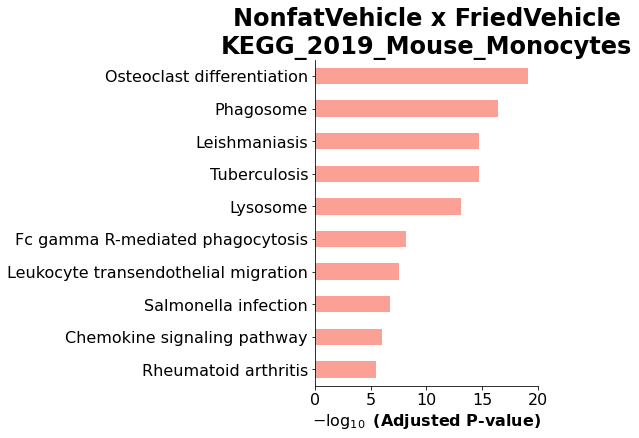

NK Cells
45
7


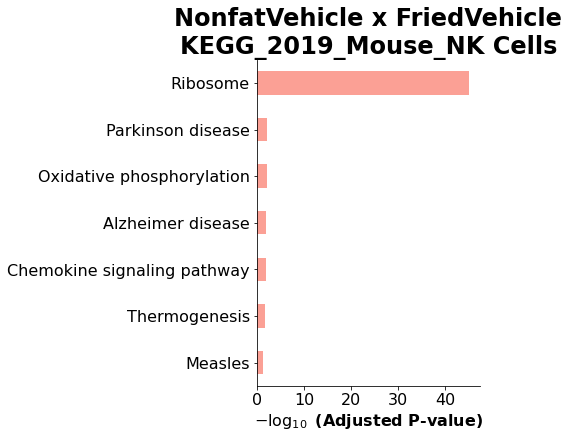

Naive CD4+
15
No Significant Stuffs
Naive CD8+
118
8


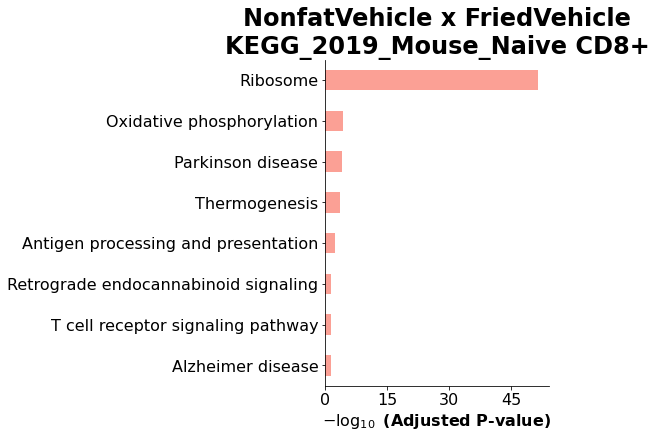

Neutrophils
No sig. genes
Peri. Macs
27
18


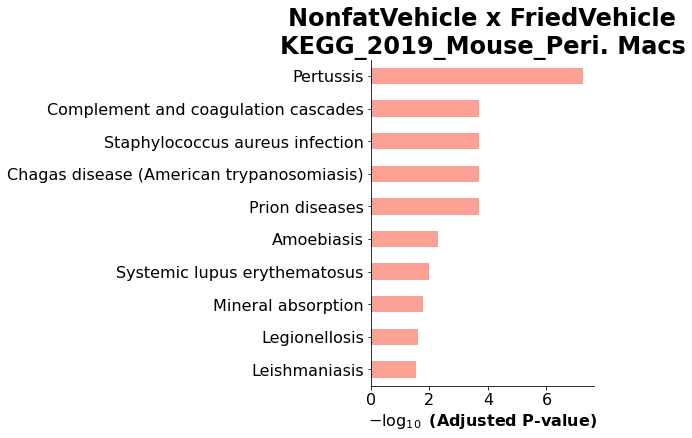

Y-Delta T Cells
9
7


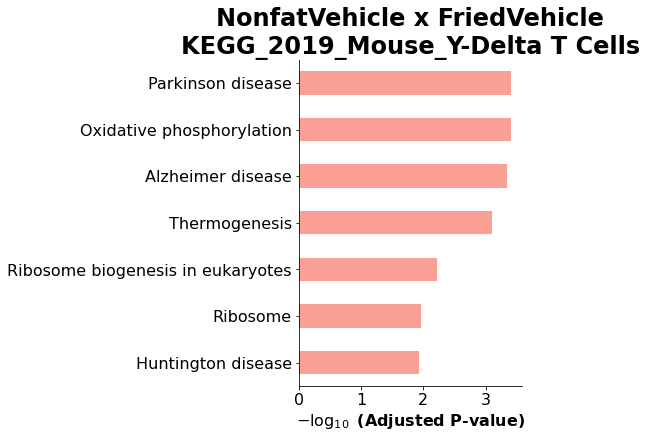

pDCs
11
7


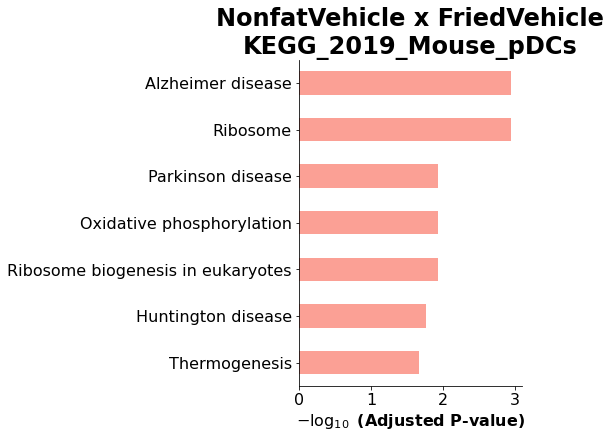


FriedVehicle x FriedCRV431


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['B Cells' 'Basophils' 'CTLs' 'CV & Cap. Macs' 'Cd79a++' 'Cholangiocytes'
 'Endothelial Cells' 'ILC1s' 'LAMs' 'Mig. cDCs' 'Monocytes' 'NK Cells'
 'Naive CD4+' 'Naive CD8+' 'Neutrophils' 'Pat. Mono' 'Stellate Cells'
 'Stmn1++' 'TRegs' 'Trans. Mono' 'Y-Delta T Cells' 'cDC1s' 'cDC2s' 'pDCs']
B Cells
44
9


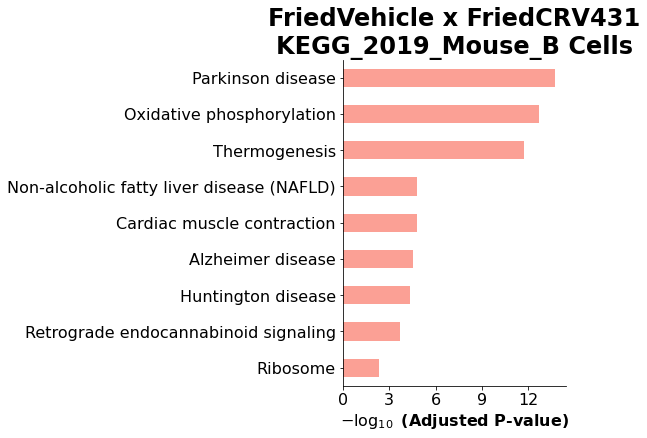

Basophils
No sig. genes
CTLs
48
9


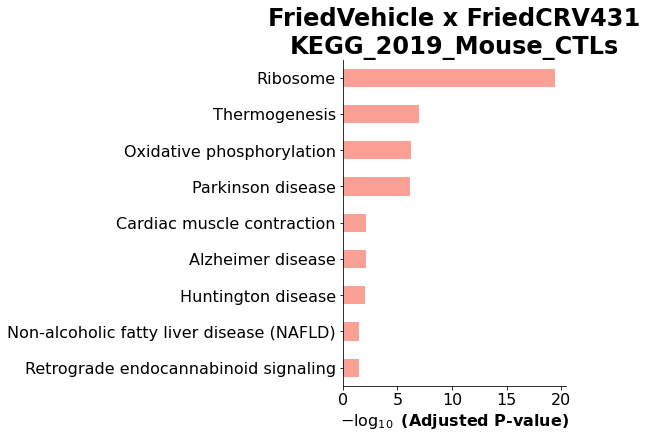

CV & Cap. Macs
75
15


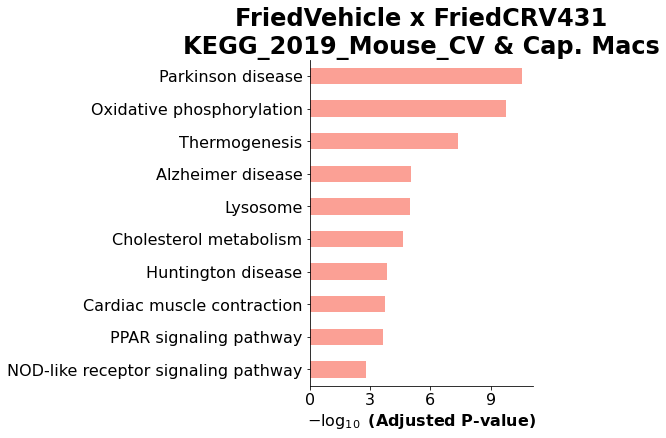

Cholangiocytes
No sig. genes
Endothelial Cells
No sig. genes
ILC1s
22
8


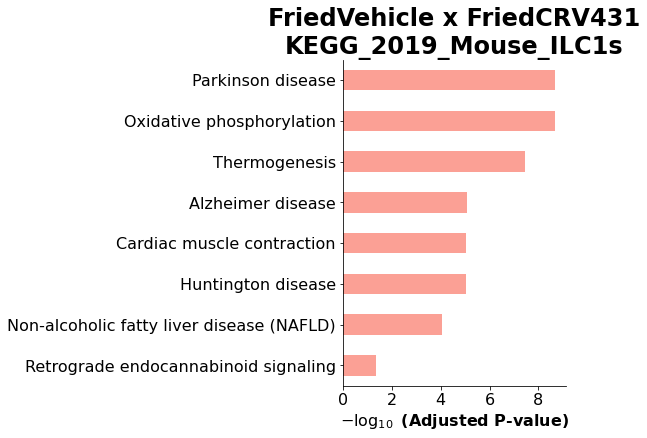

LAMs
353
80


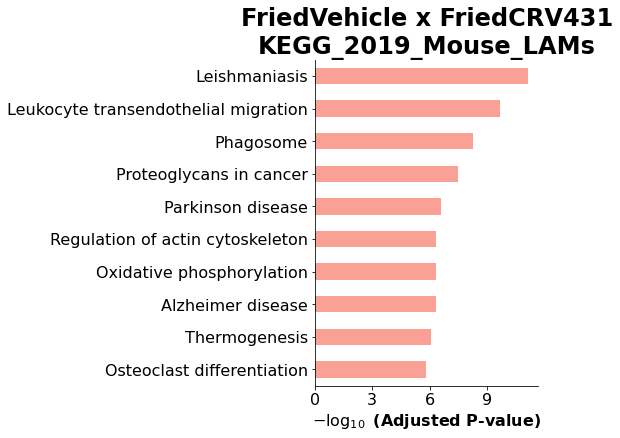

Mig. cDCs
3
7


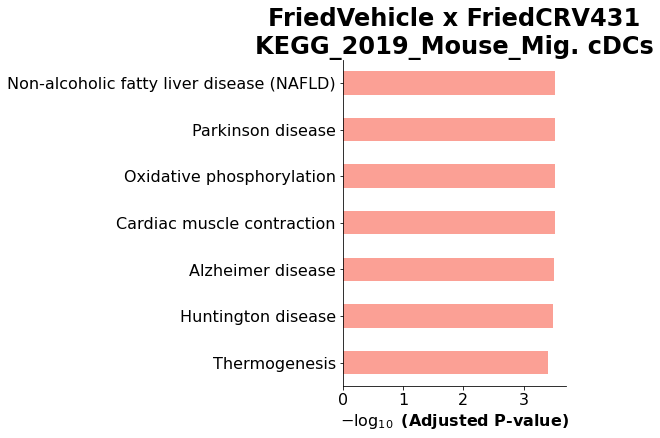

Monocytes
89
8


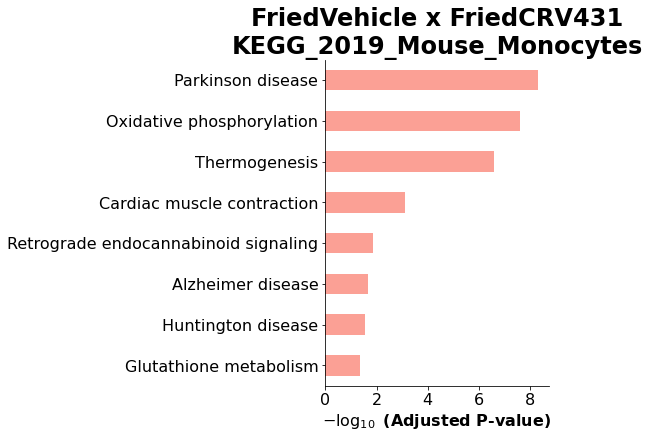

NK Cells
7
8


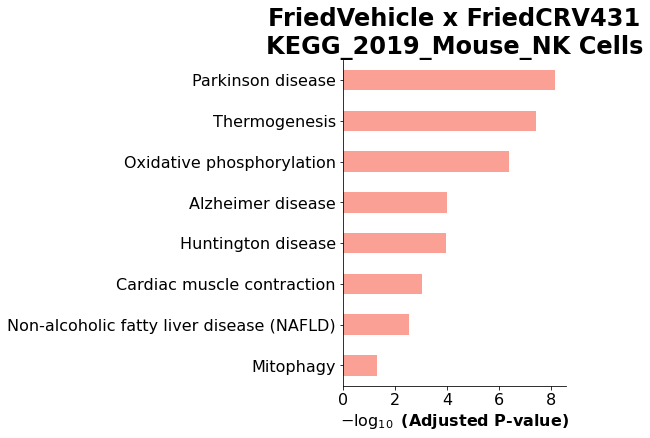

Naive CD4+
8
8


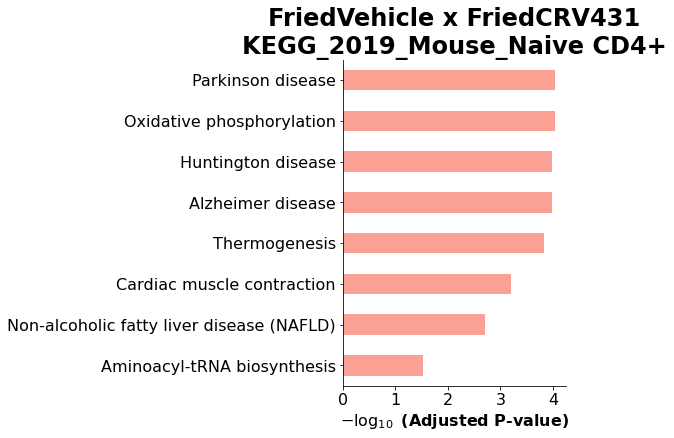

Naive CD8+
71
15


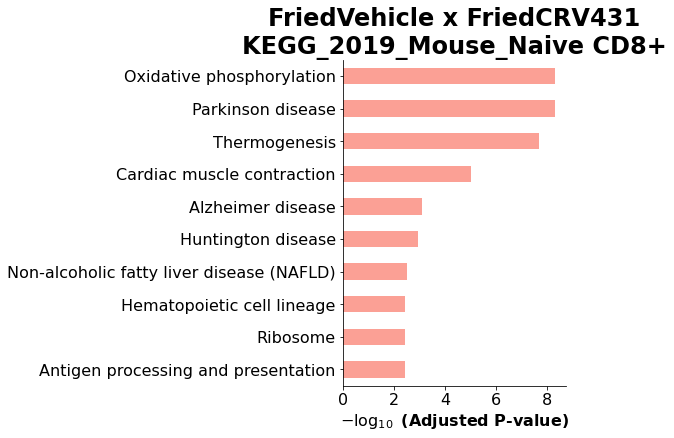

Neutrophils
71
18


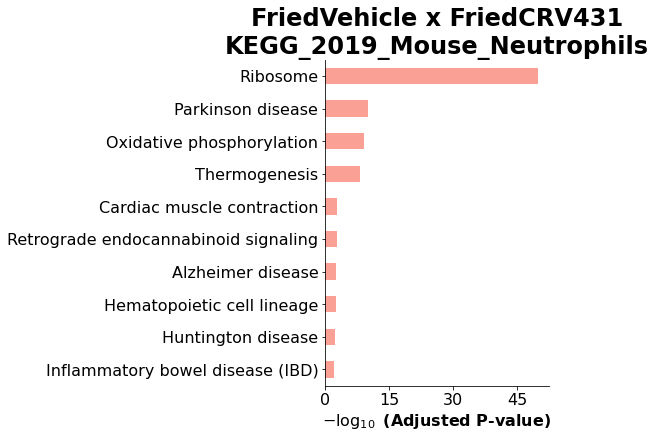

Pat. Mono
42
26


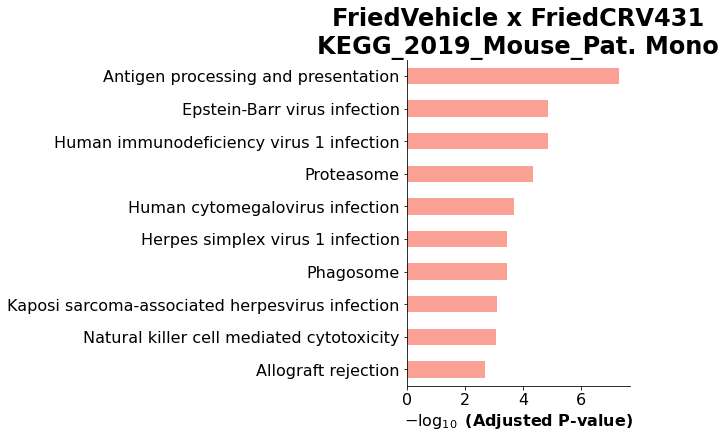

Stellate Cells
No sig. genes
Stmn1++
No sig. genes
TRegs
5
9


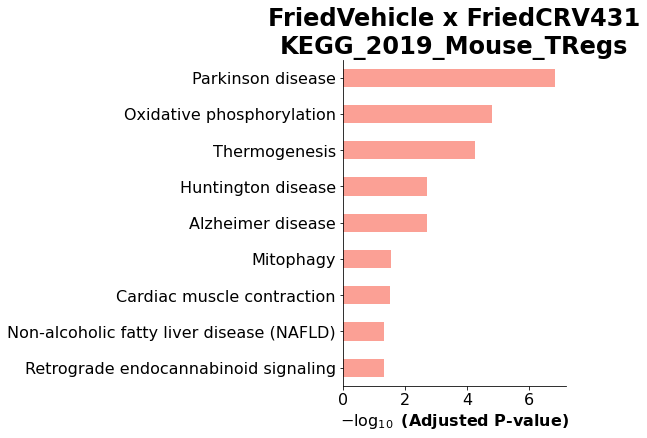

Trans. Mono
350
60


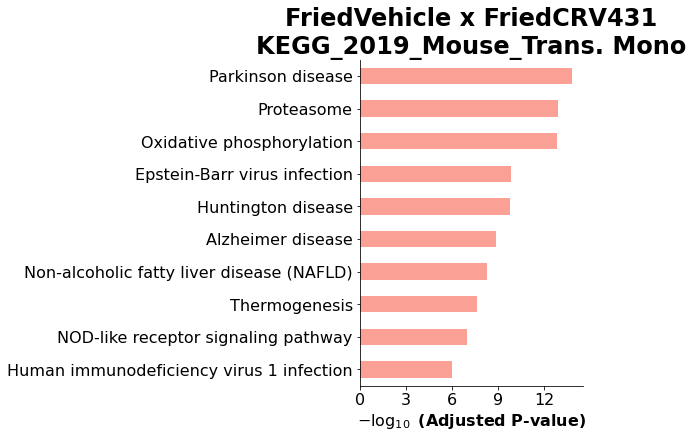

Y-Delta T Cells
No sig. genes
cDC1s
4
7


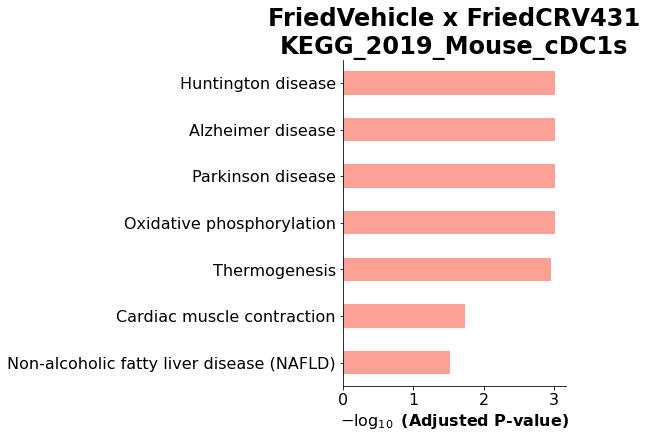

cDC2s
19
10


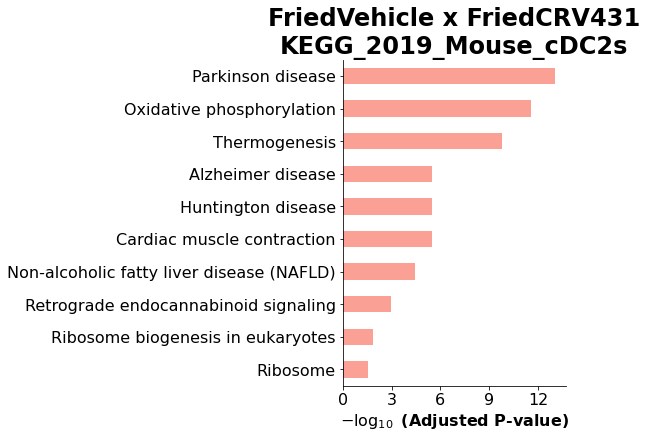

pDCs
10
9


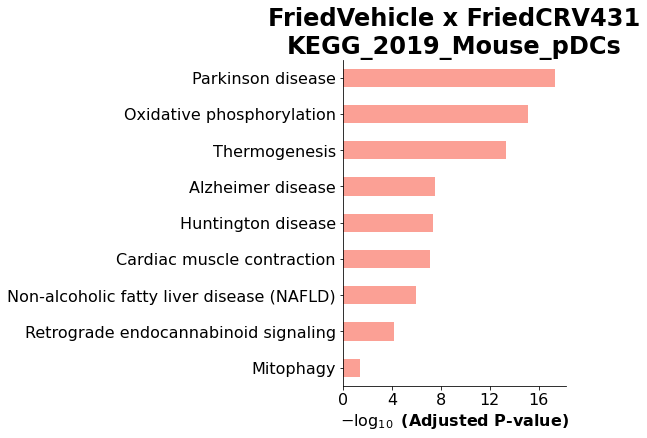


FriedVehicle x FriedLANI


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['B Cells' 'Basophils' 'CTLs' 'CV & Cap. Macs' 'Cd79a++' 'Cholangiocytes'
 'Endothelial Cells' 'H2-Ab1++' 'Hepatocytes' 'ILC1s' 'Jchain++'
 'Kupffer Cells' 'LAMs' 'Mig. cDCs' 'Monocytes' 'NK Cells' 'Naive CD4+'
 'Naive CD8+' 'Neutrophils' 'Pat. Mono' 'Peri. Macs' 'Stellate Cells'
 'Stmn1++' 'TRegs' 'Trans. Mono' 'Y-Delta T Cells' 'cDC1s' 'cDC2s' 'pDCs']
B Cells
10
10


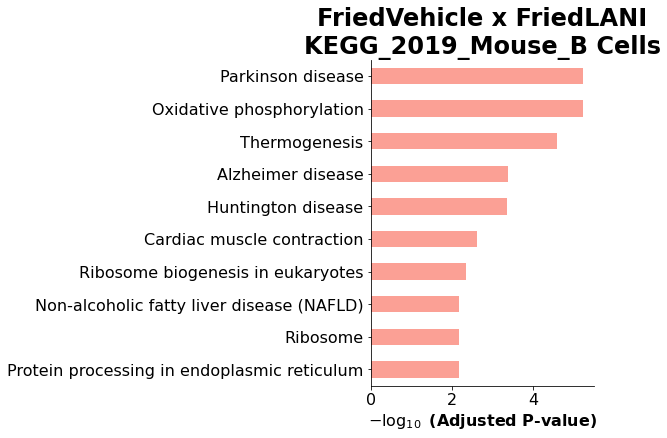

Basophils
No sig. genes
CTLs
7
9


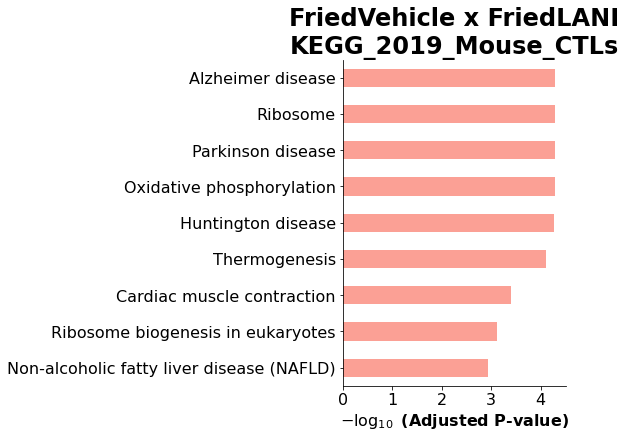

CV & Cap. Macs
115
43


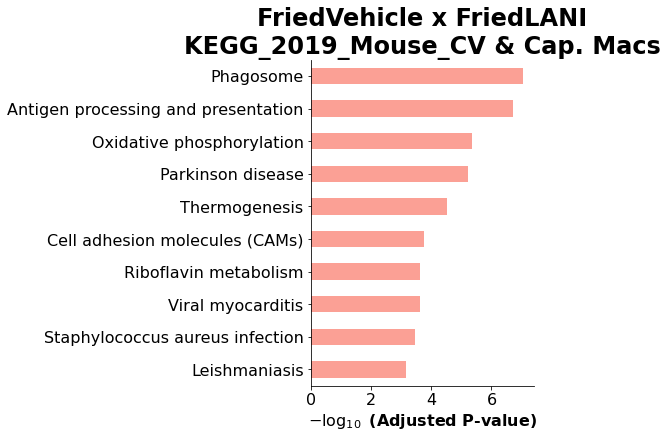

Cholangiocytes
3
7


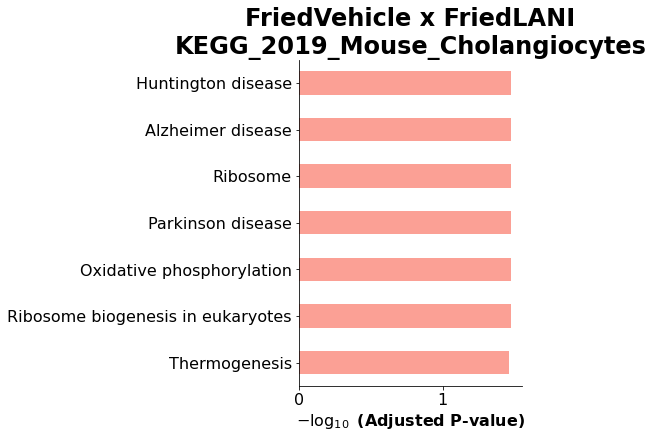

Endothelial Cells
No sig. genes
Hepatocytes
No sig. genes
ILC1s
13
11


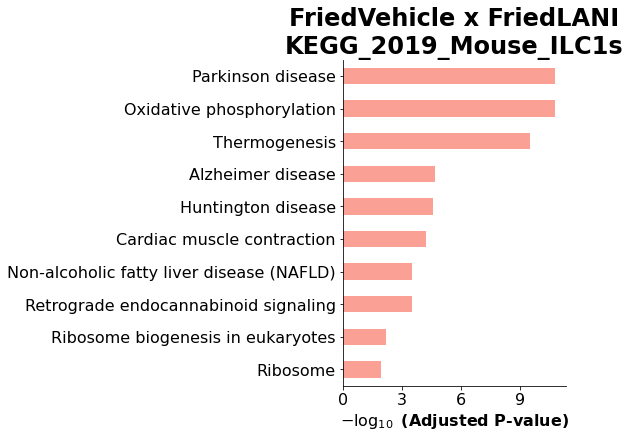

Jchain++
No sig. genes
Kupffer Cells
62
27


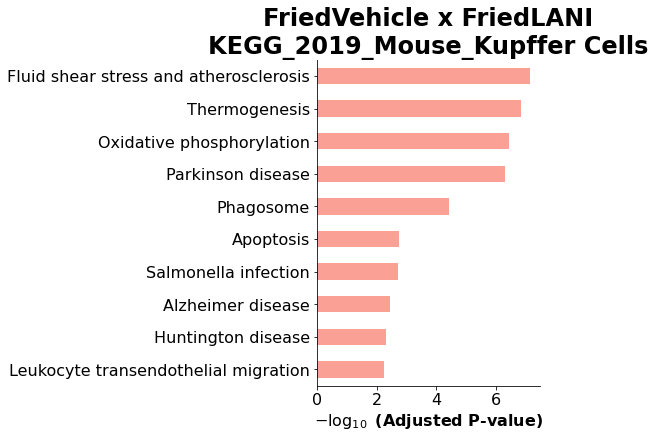

LAMs
64
40


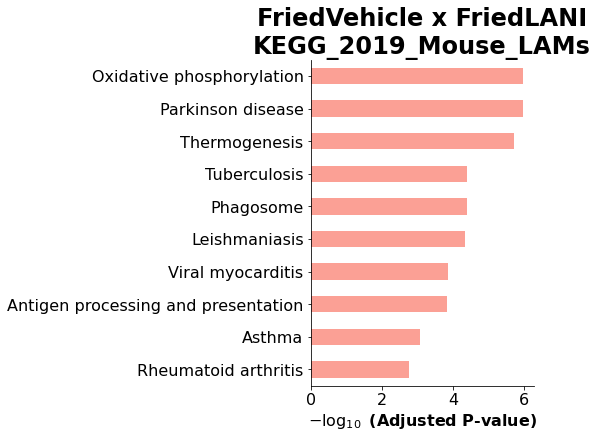

Mig. cDCs
7
9


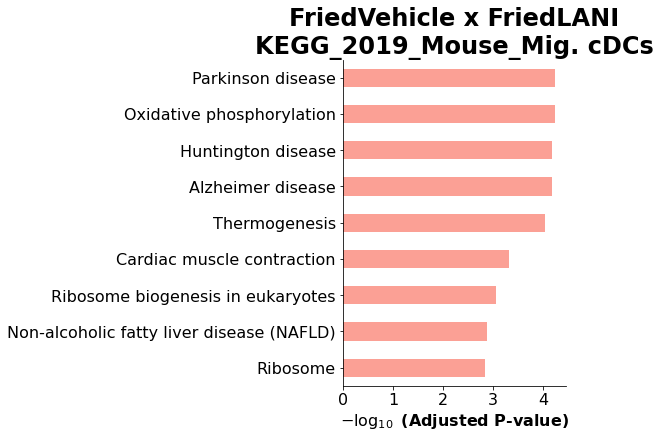

Monocytes
48
3


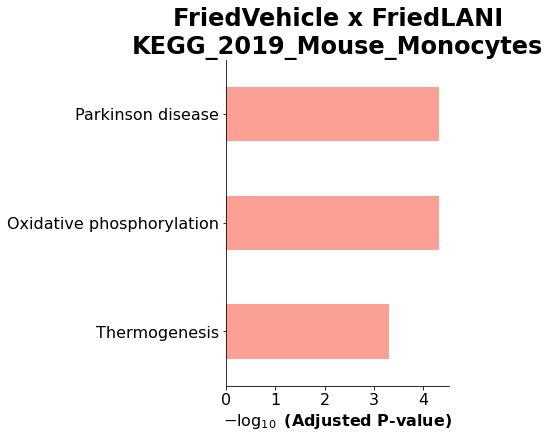

NK Cells
6
9


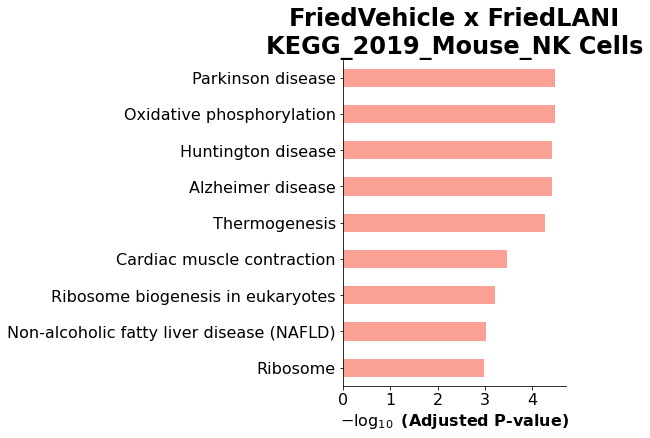

Naive CD4+
10
11


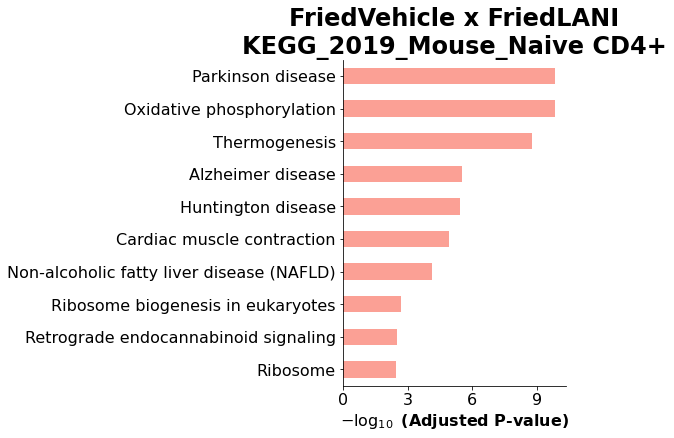

Naive CD8+
15
10


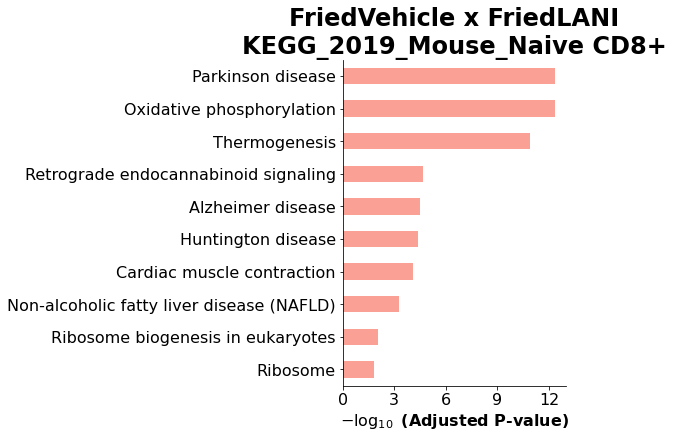

Neutrophils
5
4


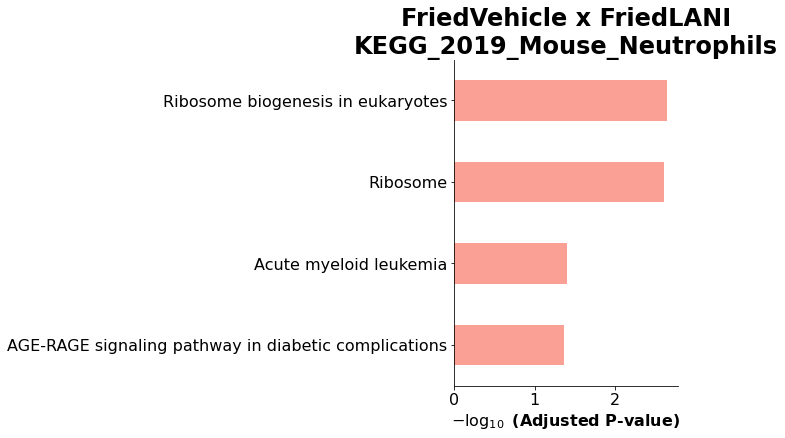

Pat. Mono
1
No Significant Stuffs
Peri. Macs
12
7


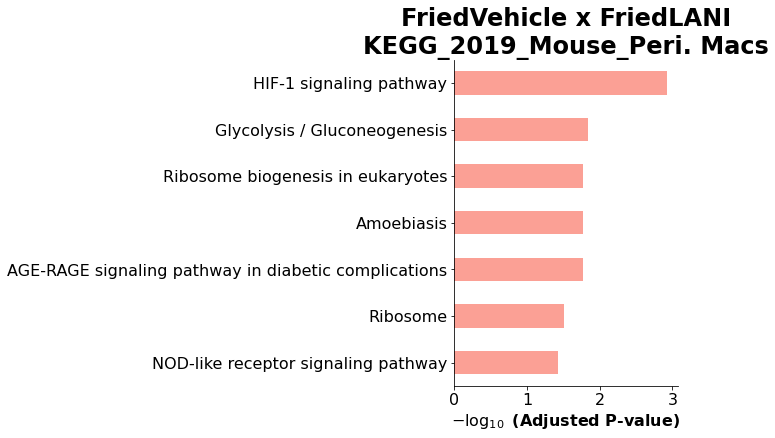

Stellate Cells
1
No Significant Stuffs
Stmn1++
1
No Significant Stuffs
TRegs
7
9


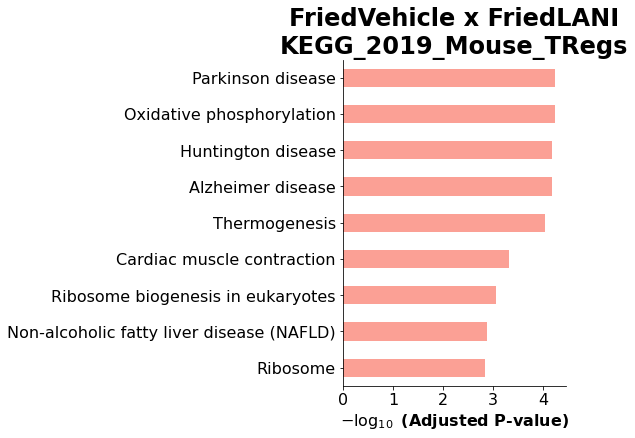

Trans. Mono
91
28


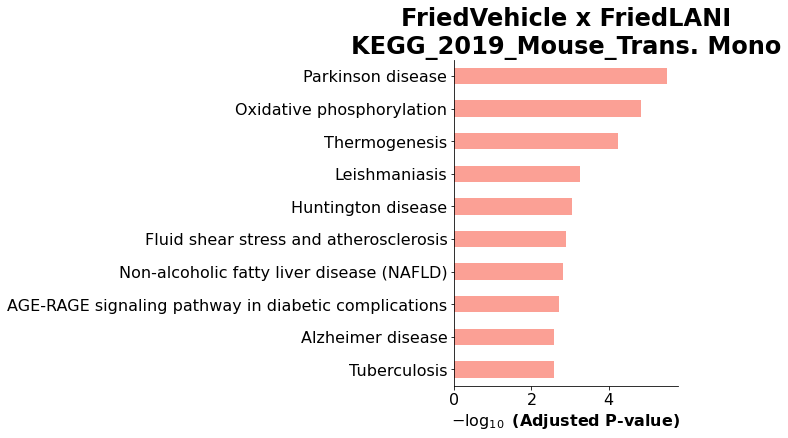

Y-Delta T Cells
7
9


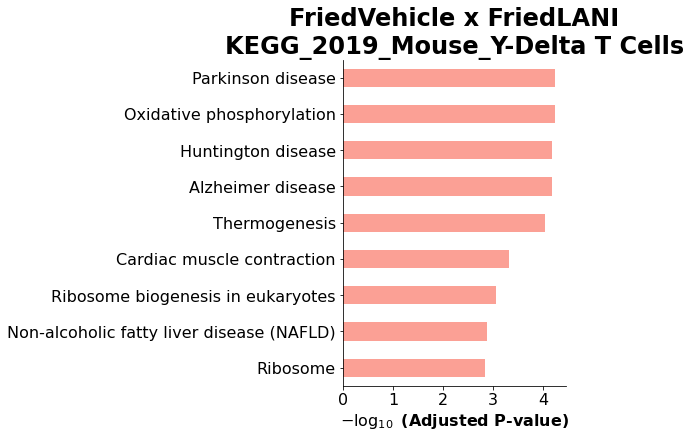

cDC1s
7
9


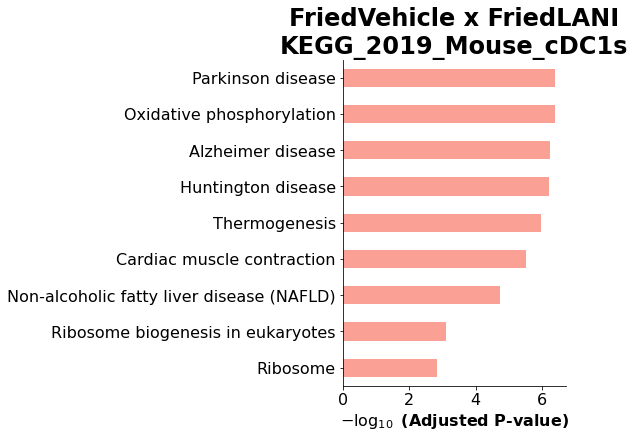

cDC2s
20
23


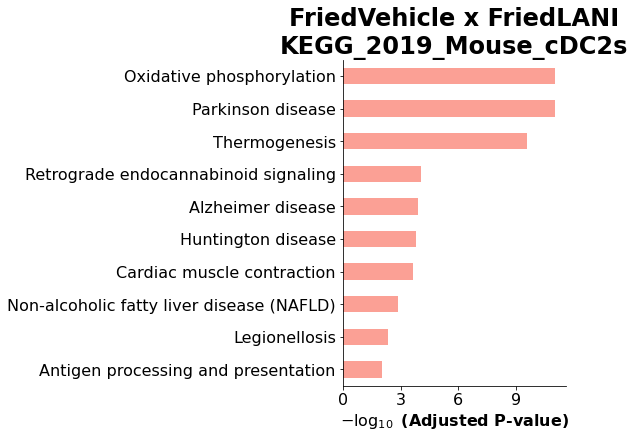

pDCs
8
7


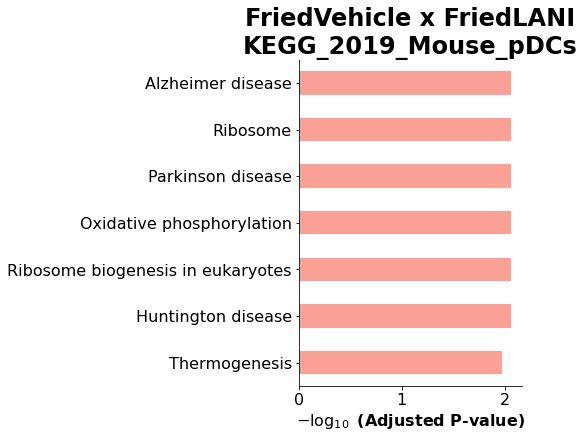


FriedVehicle x FriedCRVLAN


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['B Cells' 'Basophils' 'CTLs' 'CV & Cap. Macs' 'Cholangiocytes'
 'Endothelial Cells' 'Hepatocytes' 'ILC1s' 'Kupffer Cells' 'LAMs'
 'Mig. cDCs' 'Monocytes' 'NK Cells' 'NKT Cells' 'Naive CD4+' 'Naive CD8+'
 'Neutrophils' 'Pat. Mono' 'Stellate Cells' 'Stmn1++' 'TRegs' 'Th1s'
 'Trans. Mono' 'VSMCs' 'Y-Delta T Cells' 'cDC1s' 'cDC2s' 'pDCs']
B Cells
40
4


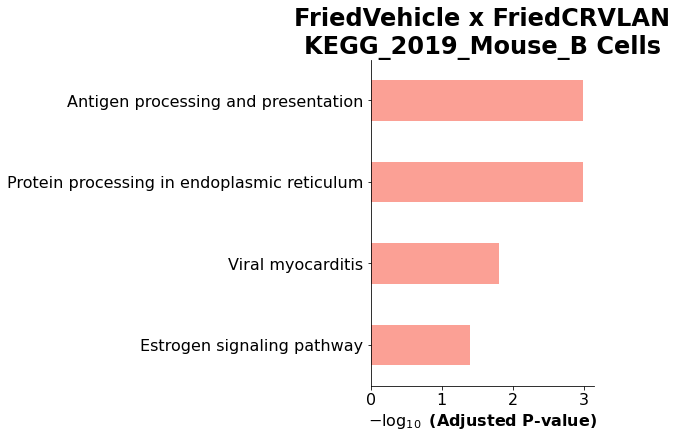

Basophils
3
1


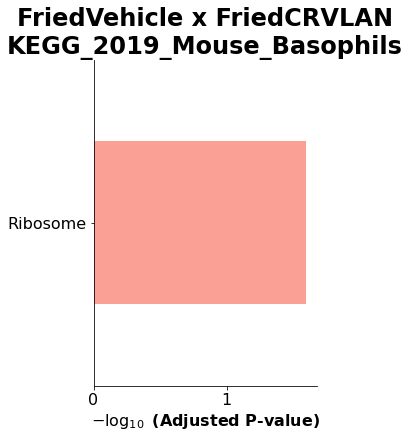

CTLs
27
4


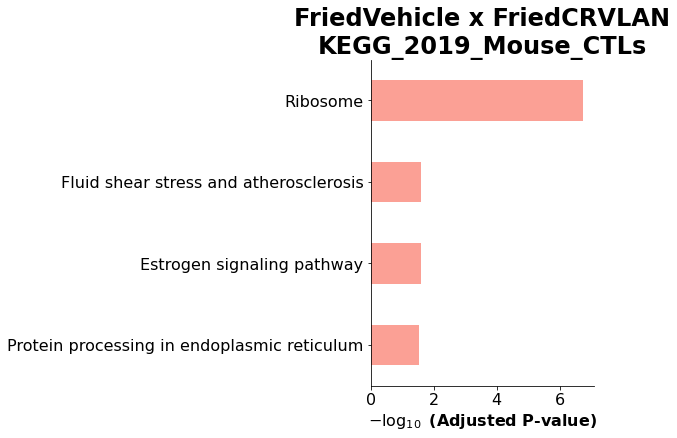

CV & Cap. Macs
106
23


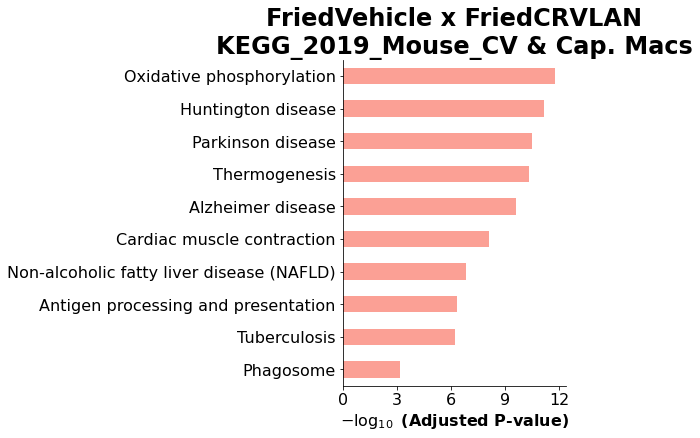

Cholangiocytes
3
4


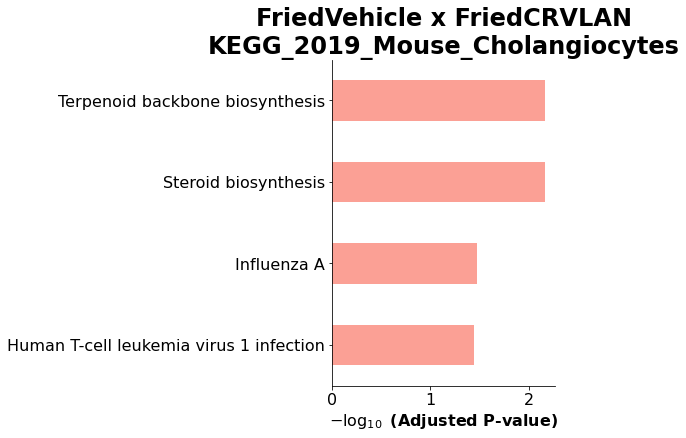

Endothelial Cells
No sig. genes
Hepatocytes
No sig. genes
ILC1s
64
17


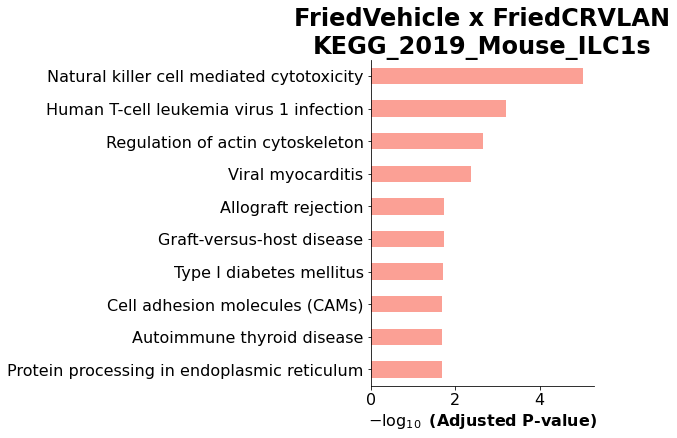

Kupffer Cells
389
131


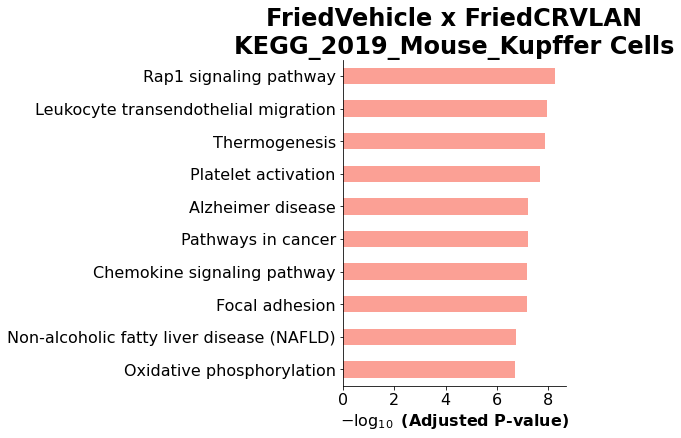

LAMs
54
44


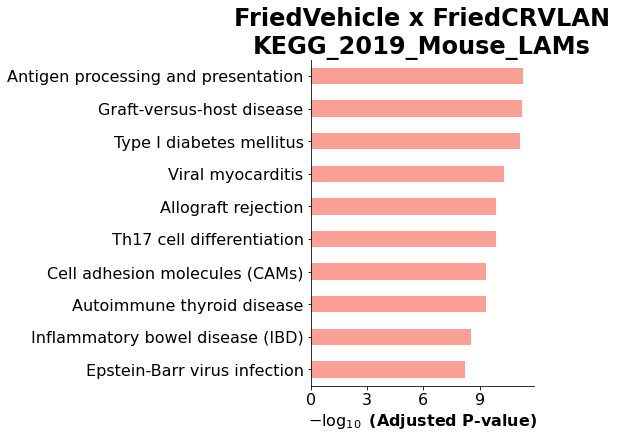

Mig. cDCs
1
No Significant Stuffs
Monocytes
96
1


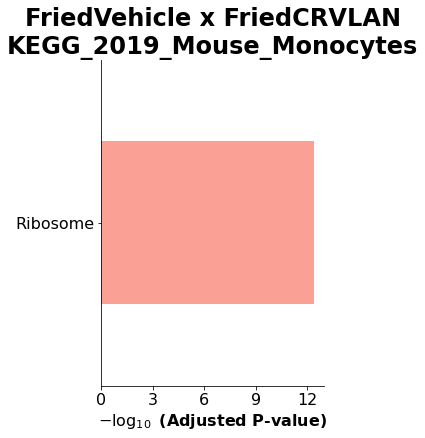

NK Cells
45
27


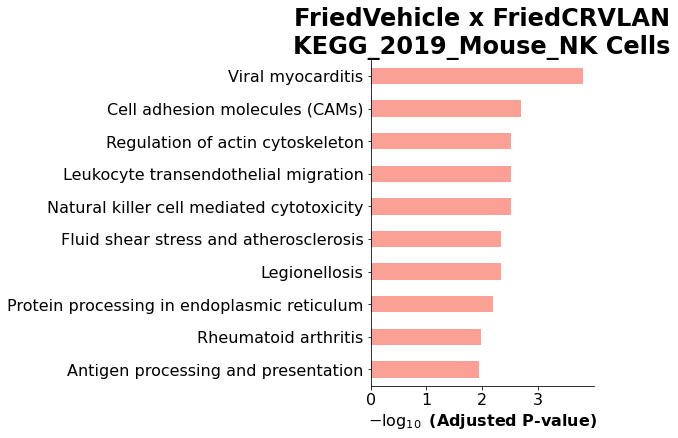

Naive CD4+
13
4


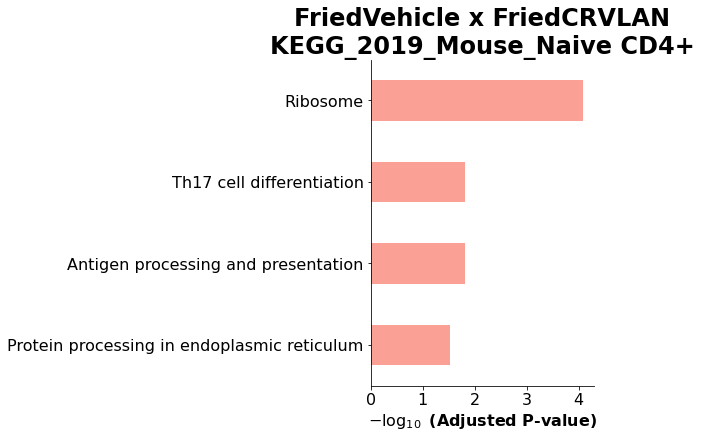

Naive CD8+
51
2


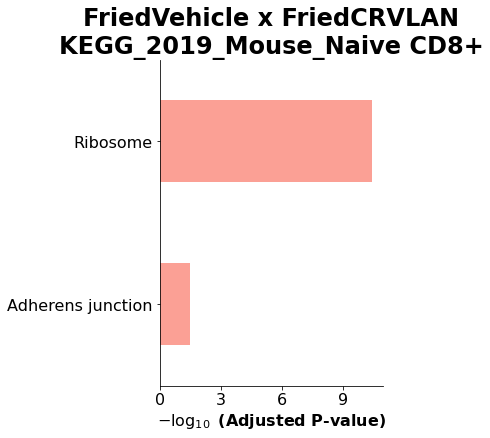

Neutrophils
46
1


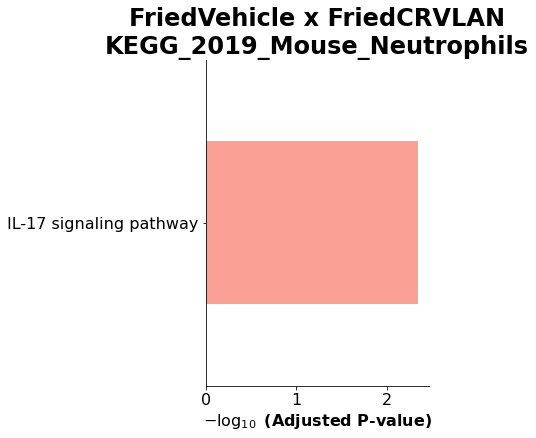

Pat. Mono
21
9


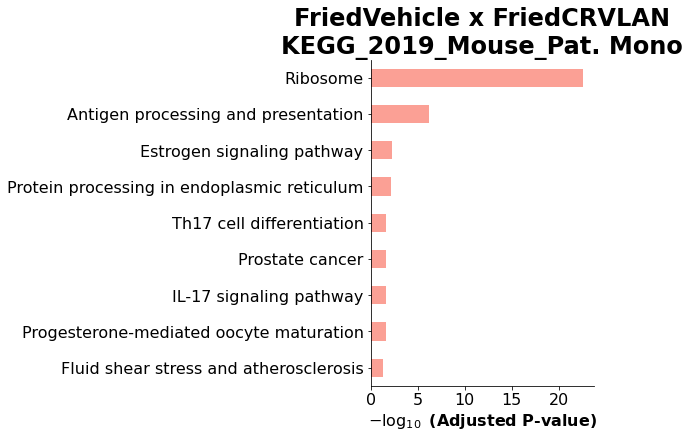

Stellate Cells
No sig. genes
Stmn1++
1
No Significant Stuffs
TRegs
6
1


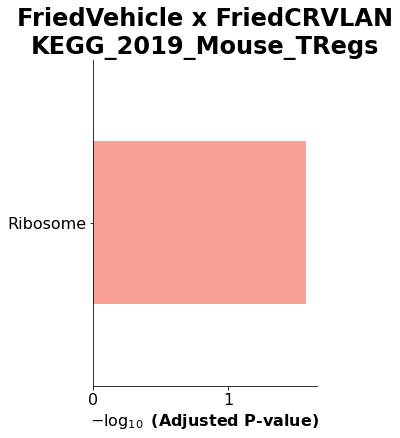

Trans. Mono
298
66


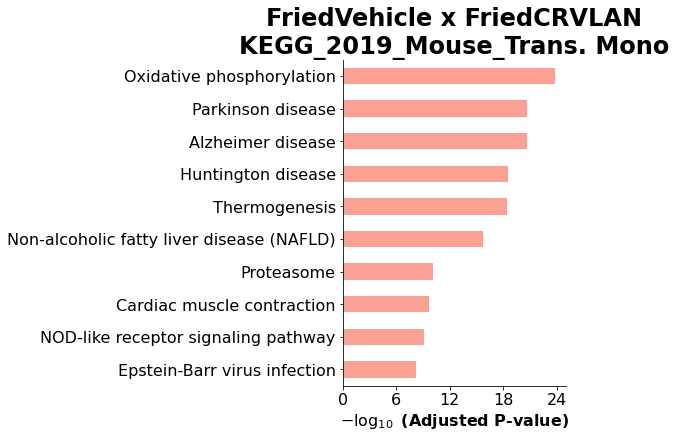

Y-Delta T Cells
6
2


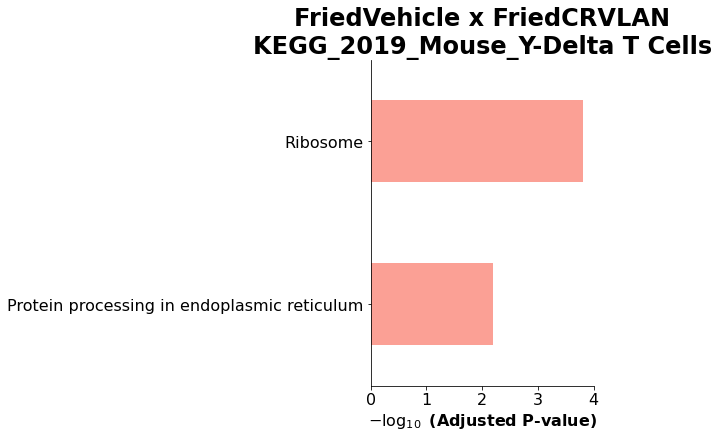

cDC1s
2
1


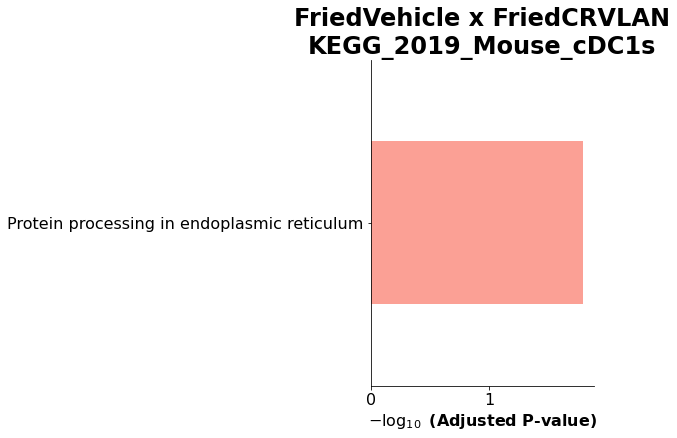

cDC2s
25
22


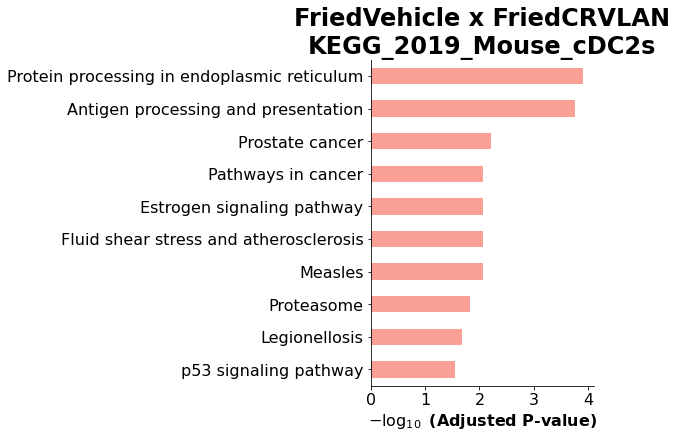

pDCs
19
19


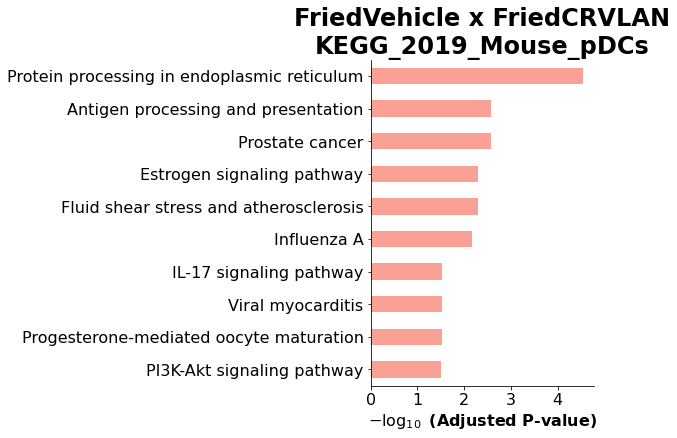


FriedCRV431 x FriedLANI


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['B Cells' 'Basophils' 'CTLs' 'CV & Cap. Macs' 'Cd79a++' 'Cholangiocytes'
 'Endothelial Cells' 'H2-Ab1++' 'Hepatocytes' 'ILC1s' 'Jchain++'
 'Kupffer Cells' 'LAMs' 'Mig. cDCs' 'Monocytes' 'NK Cells' 'Naive CD4+'
 'Naive CD8+' 'Neutrophils' 'Pat. Mono' 'Peri. Macs' 'Stellate Cells'
 'Stmn1++' 'TRegs' 'Trans. Mono' 'Y-Delta T Cells' 'cDC1s' 'cDC2s' 'pDCs']
B Cells
18
17


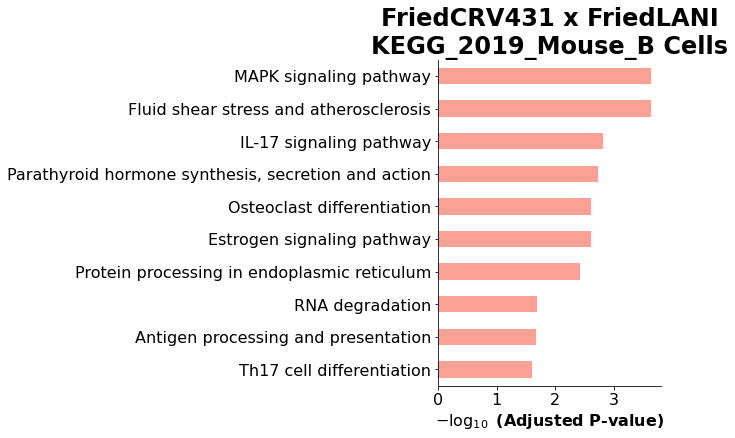

Basophils
No sig. genes
CTLs
20
10


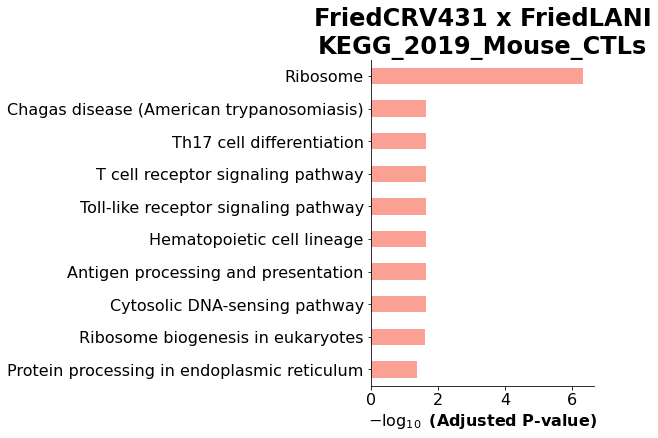

CV & Cap. Macs
43
63


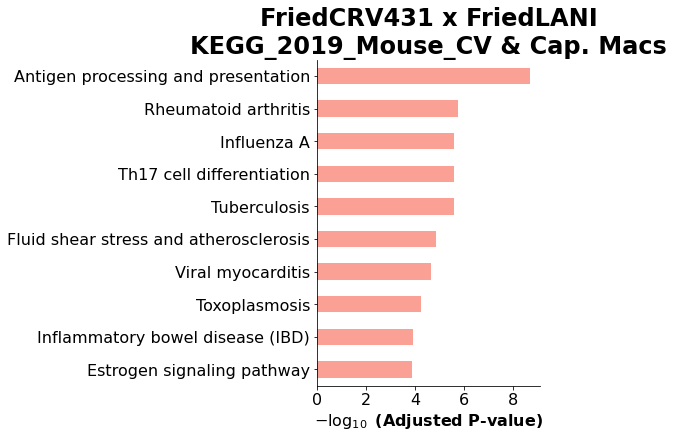

Cd79a++
No sig. genes
Cholangiocytes
No sig. genes
Endothelial Cells
No sig. genes
ILC1s
8
3


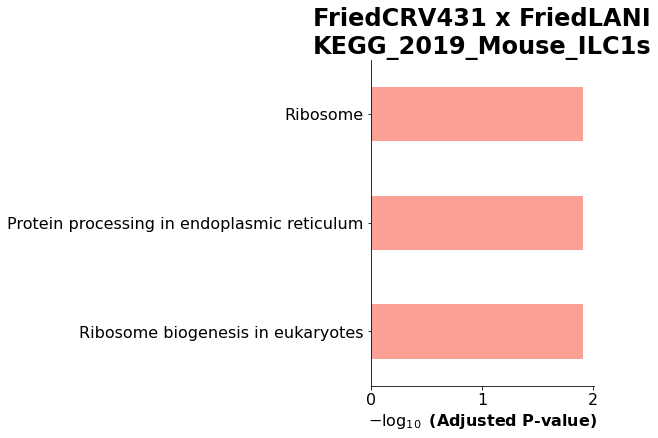

LAMs
45
31


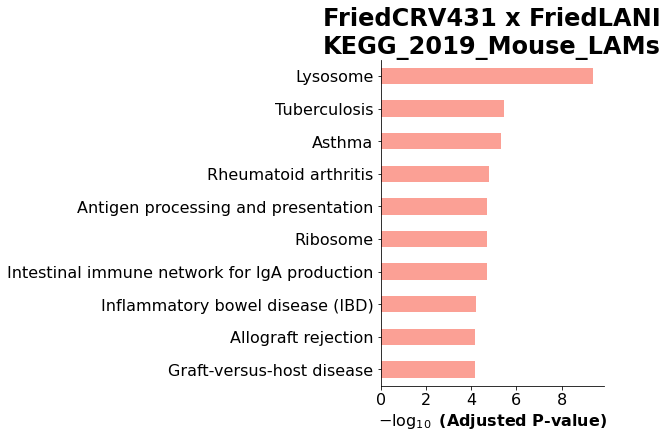

Mig. cDCs
No sig. genes
Monocytes
19
40


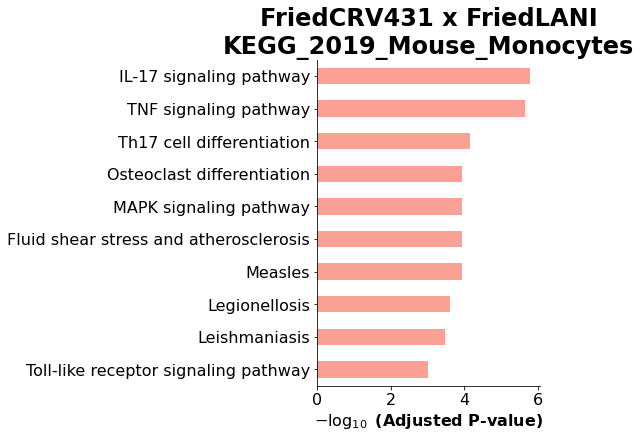

NK Cells
13
15


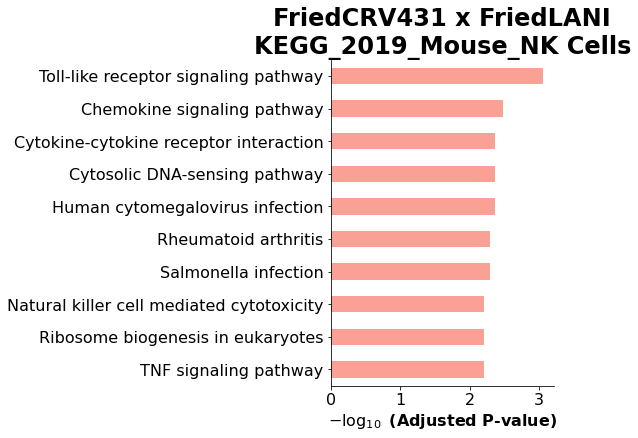

Naive CD4+
8
7


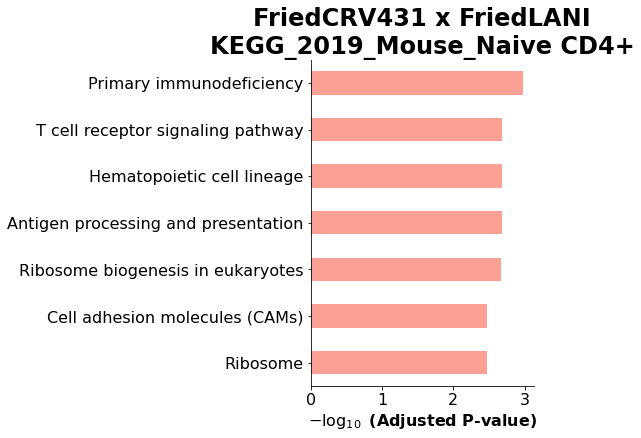

Naive CD8+
54
28


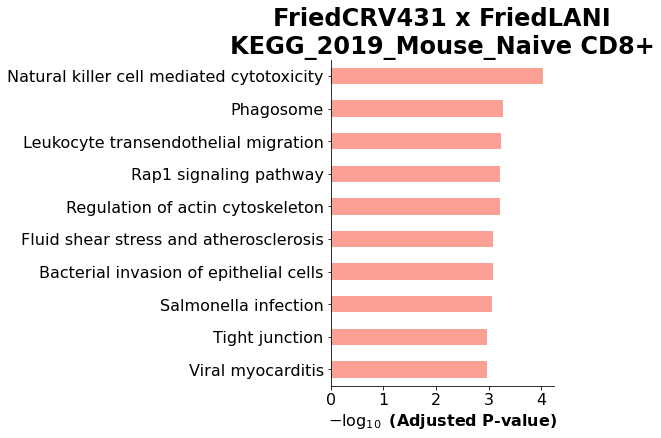

Neutrophils
19
3


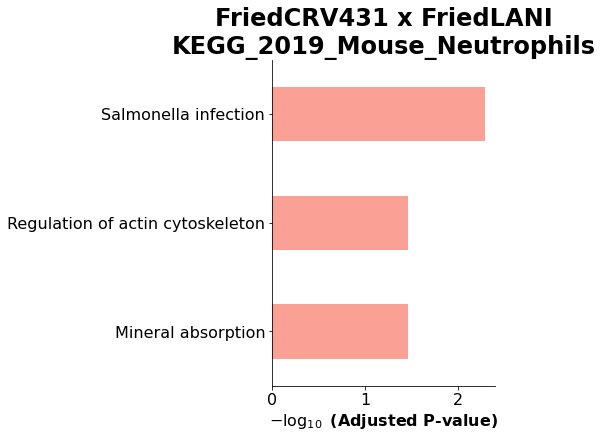

Pat. Mono
10
4


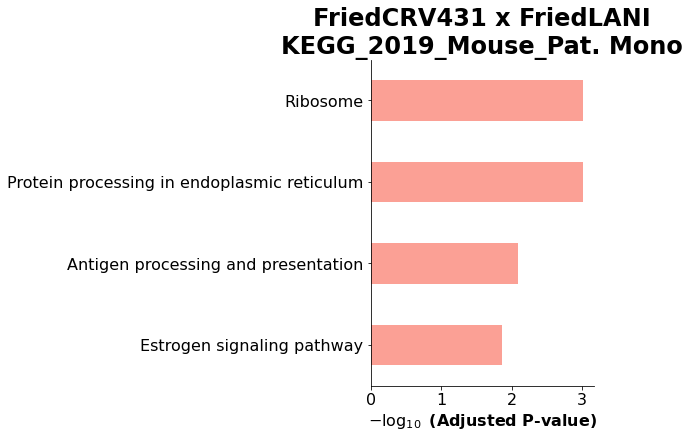

Stellate Cells
No sig. genes
Stmn1++
1
11


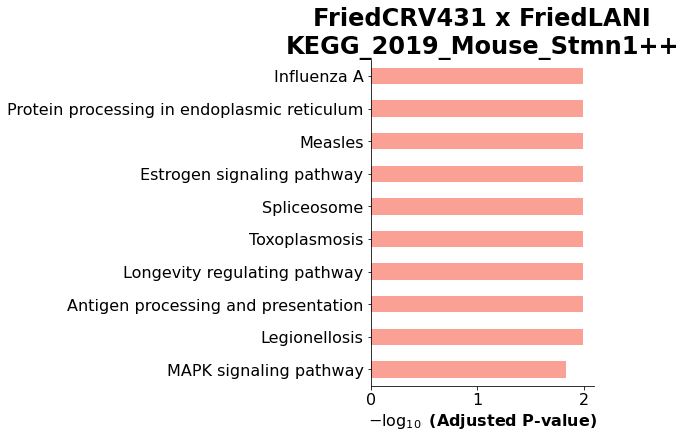

TRegs
4
3


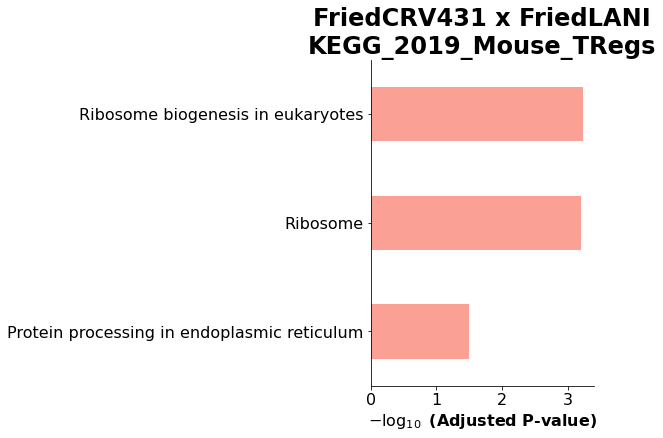

Trans. Mono
58
54


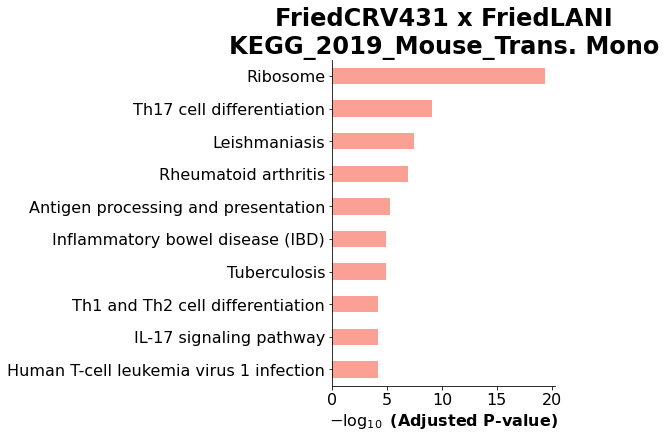

Y-Delta T Cells
5
2


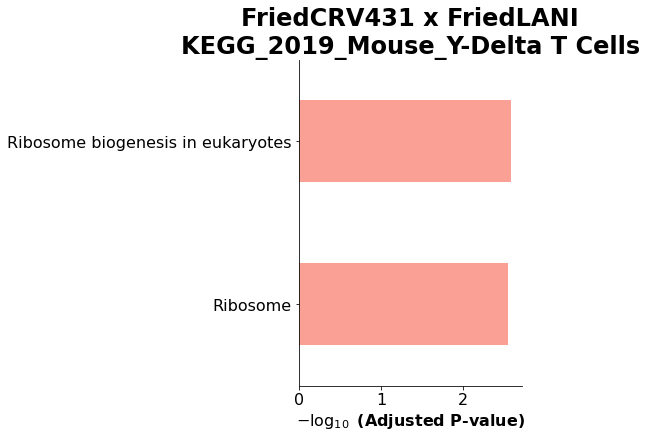

cDC1s
1
No Significant Stuffs
cDC2s
13
28


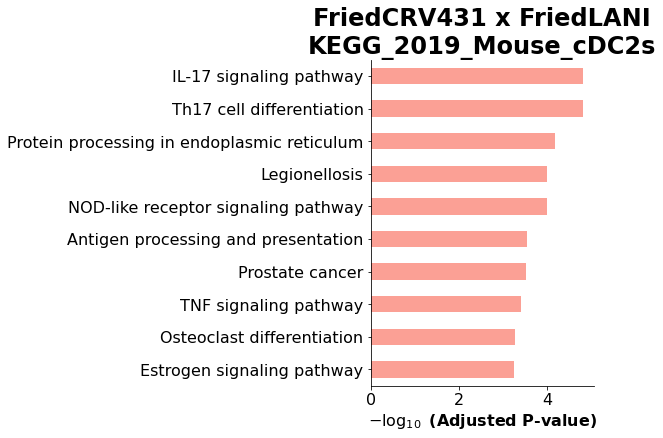

pDCs
9
15


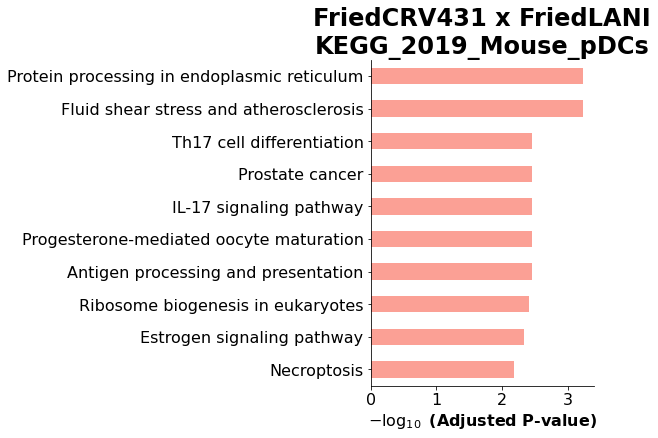

                        Comparison         Gene_set Cell Type  \
0     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
1     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
2     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
3     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
4     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
...                            ...              ...       ...   
1998       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
1999       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2000       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2001       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2002       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   

                                             Term Overlap  Adjusted P-value  \
0                       Oxidative phosphorylation  13/134          0.000006   
1                                        Ribosome  14/170    

In [36]:
#gene_set_names = gseapy.get_library_name(organism='Mouse')
#print(gene_set_names)

treatments1 = ['NonfatVehicle','FriedVehicle', 'FriedVehicle', 'FriedVehicle', 'FriedCRV431']
treatments2 = ['FriedVehicle', 'FriedCRV431','FriedLANI','FriedCRVLAN', 'FriedLANI']
#treatments1=['FriedVehicle']
#treatments2=['FriedCRV431']
depth='fine'
analysis = ['KEGG_2019_Mouse']
save=False
bigExcel=True
#analysis = 'GO_Biological_Process_2021' #['KEGG_2019_Mouse', 'GO_Biological_Process_2021', 'WikiPathways_2019_Mouse']
savePics=False

t0 = time.time()
dfs=[]
for treat1,treat2 in zip(treatments1, treatments2):
    comparison = f"{treat1} x {treat2}"
    print('\n'+comparison)
    cadata = process.catAdata(Data, [treat1, treat2], normReads=False, combat=False)
    cadata = process.dgeNorm(cadata)
    print(np.unique(cadata[cadata.obs['batch']==treat2].obs[f'{depth}Clusters']))
    
    df = process.enrichAllCellTypes(cadata, treat1, treat2, analysis, comparison, obsKey=f'{depth}Clusters', savePics=savePics)
    '''
    cellTypes = sorted(( set(np.unique(cadata[cadata.obs['batch']==treat2].obs[f'{depth}Clusters'])) & set(np.unique(cadata[cadata.obs['batch']==treat1].obs[f'{depth}Clusters']) )))
    for cellType in cellTypes:
        #for cellType in np.unique(cadata[cadata.obs['batch']==treat2].obs[f'{depth}Clusters']):
        #print(np.unique(cadata[cadata.obs['batch']==treat1].obs[f'{depth}Clusters']))
        #if cellType in np.unique(cadata[cadata.obs['batch']==treat1].obs[f'{depth}Clusters']):
        print(cellType)
        adata = cadata[cadata.obs[f'{depth}Clusters']==cellType]
        sc.tl.rank_genes_groups(adata, 'batch', groups=[treat2], reference=treat1, use_raw=False, method='wilcoxon', max_iter=2000, pts=False, key_added = "wilcoxon")
        glist = sc.get.rank_genes_groups_df(adata, group=treat2, 
                                            key='wilcoxon', log2fc_min=0.25, 
                                            pval_cutoff=0.01)['names'].squeeze()
        if type(glist)!=str:
            glist = glist.str.strip().tolist()
        else:
              glist=[glist]

        if len(glist)>0:
            print(len(glist))
            result = process.enrich(glist, analyses=analysis, treatment=comparison, title_suffix='_'+cellType, return_df=True)[0]
            if savePics:
                plt.savefig(f"images/{comparison}_{cellType}_{analysis}.png", bbox_inches='tight')
            plt.show()
            result = result[result['Adjusted P-value']<0.1]
            result['Cell Type'] = [cellType]*result.shape[0]
            result = result[['Gene_set','Cell Type', 'Term','Overlap','Adjusted P-value','Genes']]

            df.append(result)
        else:
            print("No sig. genes")
    '''
    df= pd.concat(df, ignore_index=True)
    df['Comparison'] = [comparison]*df.shape[0]
    dfs.append(df)
    if save: df.to_csv(f"{analysis}/{comparison}.csv")
        
if bigExcel:
    bigDF = pd.concat(dfs, ignore_index=True)
    bigDF = bigDF[['Comparison', 'Gene_set','Cell Type', 'Term','Overlap','Adjusted P-value','Genes']]
    print(bigDF)
    out.makeSpreadsheet(bigDF, filename='combinedKEGG.xlsx', sheetKey='Comparison', sortKey=['Cell Type', 'Adjusted P-value'])
    

print("Finished")
print(f"{time.time()-t0}s")

In [32]:
bigDF = bigDF[['Comparison', 'Gene_set','Cell Type', 'Term','Overlap','Adjusted P-value','Genes']]
print(bigDF)
out.makeSpreadsheet(bigDF, filename='combinedKEGG.xlsx', sheetKey='Comparison', sortKey=['Cell Type', 'Adjusted P-value'])


                        Comparison         Gene_set Cell Type  \
0     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
1     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
2     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
3     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
4     NonfatVehicle x FriedVehicle  KEGG_2019_Mouse   B Cells   
...                            ...              ...       ...   
1998       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
1999       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2000       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2001       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   
2002       FriedCRV431 x FriedLANI  KEGG_2019_Mouse      pDCs   

                                             Term Overlap  Adjusted P-value  \
0                       Oxidative phosphorylation  13/134          0.000006   
1                                        Ribosome  14/170    

In [20]:
print(df.sort_values('Adjusted P-value'))
filtDF = df[df['Cell Type'] == 'LAMs']
print(filtDF.sort_values('Adjusted P-value').head(20))

            Gene_set    Cell Type                                  Term  \
216  KEGG_2019_Mouse  Neutrophils                              Ribosome   
15   KEGG_2019_Mouse         CTLs                              Ribosome   
378  KEGG_2019_Mouse         pDCs                     Parkinson disease   
379  KEGG_2019_Mouse         pDCs             Oxidative phosphorylation   
284  KEGG_2019_Mouse  Trans. Mono                     Parkinson disease   
..               ...          ...                                   ...   
359  KEGG_2019_Mouse  Trans. Mono  Toll-like receptor signaling pathway   
155  KEGG_2019_Mouse         LAMs     B cell receptor signaling pathway   
189  KEGG_2019_Mouse     NK Cells                           Endocytosis   
243  KEGG_2019_Mouse  Neutrophils   Antigen processing and presentation   
360  KEGG_2019_Mouse  Trans. Mono              Type I diabetes mellitus   

    Overlap  Adjusted P-value  \
216  34/170      1.293355e-50   
15   16/170      3.602431e-20   


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Mouse  Protein processing in endoplasmic reticulum   5/163   
1   KEGG_2019_Mouse          Antigen processing and presentation    4/90   
2   KEGG_2019_Mouse                            Viral myocarditis    3/87   
3   KEGG_2019_Mouse                   Estrogen signaling pathway   3/134   
4   KEGG_2019_Mouse               Cell adhesion molecules (CAMs)   3/170   
..              ...                                          ...     ...   
62  KEGG_2019_Mouse             Regulation of actin cytoskeleton   1/217   
63  KEGG_2019_Mouse     Human immunodeficiency virus 1 infection   1/238   
64  KEGG_2019_Mouse      Human T-cell leukemia virus 1 infection   1/245   
65  KEGG_2019_Mouse                       MAPK signaling pathway   1/294   
66  KEGG_2019_Mouse               Human papillomavirus infection   1/360   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0   0.

<AxesSubplot: title={'center': 'WikiPathways_2019_Mouse'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

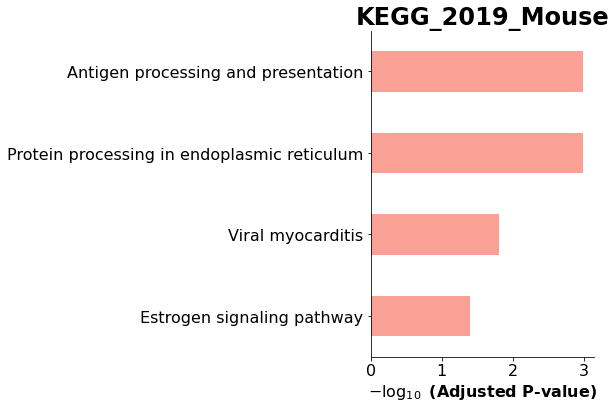

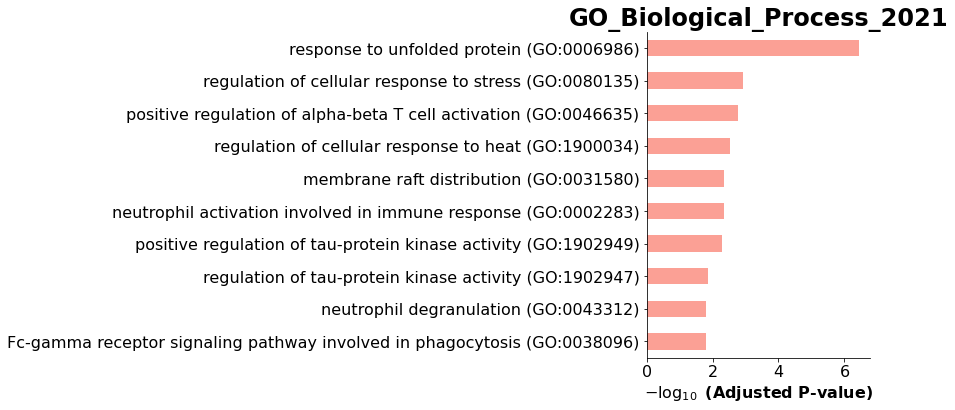

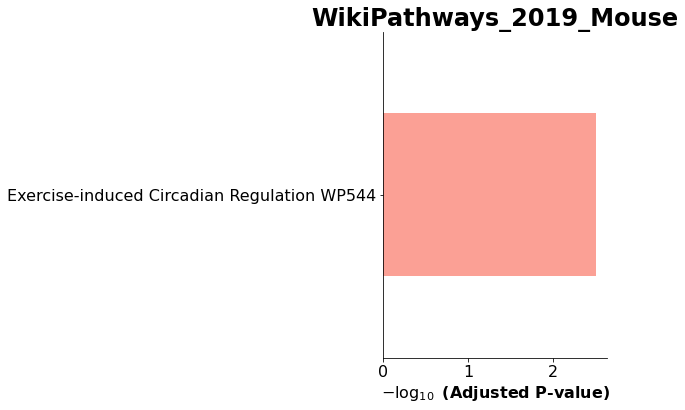

In [68]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets='KEGG_2019_Mouse',
                     cutoff = 0.5)
print(enr_res.res2d)
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse')
enr_res.results = enr_res.results[['Gene_set','Term','Overlap','Adjusted P-value','Genes']]
enr_res.results=enr_res.results[enr_res.results['Adjusted P-value']<0.1]
print(enr_res.results)

enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets='GO_Biological_Process_2021',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2021')

enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets='WikiPathways_2019_Mouse',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title='WikiPathways_2019_Mouse')

In [40]:
print(enr_res.results[['Gene_set','Term','Overlap','Adjusted P-value','Genes']])

                   Gene_set                                 Term Overlap  \
0   WikiPathways_2019_Mouse       Electron Transport Chain WP295   9/103   
1   WikiPathways_2019_Mouse         TYROBP Causal Network WP3625    7/58   
2   WikiPathways_2019_Mouse         MAPK signaling pathway WP493  10/159   
3   WikiPathways_2019_Mouse                  Focal Adhesion WP85  10/185   
4   WikiPathways_2019_Mouse   Chemokine signaling pathway WP2292  10/190   
..                      ...                                  ...     ...   
83  WikiPathways_2019_Mouse      ESC Pluripotency Pathways WP339   1/118   
84  WikiPathways_2019_Mouse                mRNA processing WP310   3/457   
85  WikiPathways_2019_Mouse                    GPCRs, Other WP41   1/155   
86  WikiPathways_2019_Mouse             Purine metabolism WP2185   1/171   
87  WikiPathways_2019_Mouse  GPCRs, Class A Rhodopsin-like WP189   1/228   

    Adjusted P-value                                              Genes  
0           0